**Environment Setup**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [3]:
pip install itables

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.1 MB/s eta 0:00:00


In [4]:
pip install pandas==2.0.3

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import numpy as np
import pandas as pd
from os.path import getsize, join, split, splitext
from glob import glob
from tqdm.notebook import tqdm
from bokeh.models import NumeralTickFormatter
import polars.selectors as cs
import warnings
import missingno as mn

pl.Config(
    fmt_str_lengths=80,
    tbl_rows=80,
    set_thousands_separator=' ',
    float_precision=1,
    set_fmt_float="full",
    tbl_cell_alignment = "LEFT",
    tbl_cell_numeric_alignment="RIGHT"
)
frmt_big_numb = NumeralTickFormatter(format='0.0a')


In [6]:
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

**Read Data**

In [7]:
MAIN_PATH = '/content/drive/MyDrive/home-credit-credit-risk-model-stability'
TRAIN_PATH_PARQUET = MAIN_PATH + '/parquet_files/train'
TEST_PATH_PARQUET = MAIN_PATH + '/parquet_files/test'
TRAIN_PATH_CSV = MAIN_PATH + '/csv_files/train'
TEST_PATH_CSV = MAIN_PATH + '/csv_files/test'

# Feature Description

In [8]:
file_path = MAIN_PATH + '/feature_definitions.csv'
df_feature_definitions = pl.read_csv(file_path)
with pl.Config() as cfg:
    cfg.set_fmt_str_lengths(50)
    display(df_feature_definitions.head())

shape: (5, 2)
┌─────────────────────────┬────────────────────────────────────────────────────┐
│ Variable                ┆ Description                                        │
│ ---                     ┆ ---                                                │
│ str                     ┆ str                                                │
╞═════════════════════════╪════════════════════════════════════════════════════╡
│ actualdpd_943P          ┆ Days Past Due (DPD) of previous contract (actual). │
│ actualdpdtolerance_344P ┆ DPD of client with tolerance.                      │
│ addres_district_368M    ┆ District of the person's address.                  │
│ addres_role_871L        ┆ Role of person's address.                          │
│ addres_zip_823M         ┆ Zip code of the address.                           │
└─────────────────────────┴────────────────────────────────────────────────────┘

In [9]:
def get_feature_definitions(columns):
    return pl.DataFrame({'Variable': columns}).join(
        df_feature_definitions,
        on = 'Variable',
        how = 'left',
    )

In [11]:
with pl.Config() as cfg:
    cfg.set_fmt_str_lengths(50)
    display(get_feature_definitions(['actualdpd_943P', 'addres_zip_823M']))

shape: (2, 2)
┌─────────────────┬────────────────────────────────────────────────────┐
│ Variable        ┆ Description                                        │
│ ---             ┆ ---                                                │
│ str             ┆ str                                                │
╞═════════════════╪════════════════════════════════════════════════════╡
│ actualdpd_943P  ┆ Days Past Due (DPD) of previous contract (actual). │
│ addres_zip_823M ┆ Zip code of the address.                           │
└─────────────────┴────────────────────────────────────────────────────┘

Some features should be of dtype date (or datetime).

Various predictors were transformed, therefore we have the following notation for similar groups of transformations

*   P - Transform DPD (Days past due)
*   M - Masking categories
*   A - Transform amount
*   D - Transform date
*   T - Unspecified Transform
*   L - Unspecified Transform

Please note that transformations within a group are denoted by a capital letter at the end of the predictor name (e.g.maxdbddpdtollast6m_4187119P). We hope that this will simplify the manipulation with predictors.

We cast columns ending D to datetime at read time. Also note that we use `pl.scan_parquet()` to save memory.

# Plotting Function

In [12]:
#Columns D convert to datetime type
def scan_data_and_parse_dates(parquet_file):
    return pl.scan_parquet(parquet_file).with_columns(
        pl.col(r'^.*D$').str.to_datetime(),
    )

In [13]:
#Function to plot (hist+kde & box) features of a specific transformation group.
def plot_numerical(df, group, max_samples = 1000000):
    X = df.select(pl.col(f'^.*{group}$')).collect()
    if len(X) > max_samples:
        X = X.sample(max_samples, seed = 0)
    n = X.shape[1]
    fig, axes = plt.subplots(n, 2, figsize = (16, n * 4), squeeze = False)
    for i, c in enumerate(X.iter_columns()):
        x = c.to_pandas()
        sns.histplot(x = x, bins = 50, kde = True, ax = axes[i, 0])
        sns.boxplot(y = x, ax = axes[i, 1])
    fig.tight_layout()

This code defines a function `plot _numerical` that plots histograms with kernel densityestimates (hist+kde) and boxplots for features of a specific transformation group in the providedDataFrame `df`. lt limits the number of samples to `max_samples` to manage memory usageefficiently. Each feature in the group is plotted in a separate subplot, with histograms on the leftand boxplots on the right. The function aims to provide visual insights into the distribution andVariability of features after a particular transformation.

In [14]:
#Function to plot (count & pie) features of a specific transformation group.
def plot_categorical(df, group, max_categories=30, max_samples=1000000):
    X = df.select(pl.col(f'^.*{group}$')).collect()
    if len(X) > max_samples:
        X = X.sample(max_samples, seed=0)
    n = X.shape[1]
    fig, axes = plt.subplots(n, 2, figsize=(16, n * 4), squeeze=False)
    for i, c in enumerate(X.iter_columns()):
        x = c.to_pandas()
        s = x.value_counts()
        if len(s) > max_categories:
            other_count = s[max_categories:].sum()
            s = s[:max_categories]
            s['Other'] = other_count
        sns.barplot(x=s.index, y=s, ax=axes[i, 0])
        for idx, val in enumerate(s):
            axes[i, 0].text(idx, val, str(val), ha='center', va='bottom')
        axes[i, 1].pie(s, labels=s.index)
    fig.tight_layout()


This function, `plot_categorical`, is designed to visualize categorical data. lt accepts a Pandas-Lightning DataFrame (`df`), a string indicating the group of categorical features to plot (`group`)and optional parameters to limit the number of categories displayed (`max_categories`) and thenumber of samples considered (`max_samples`). lt collects the columns matching the specifiedgroup, optionally samples the data if the number of samples exceeds a threshold, and createssubplots for each column. For each column, it computes the value counts and plots a bar plot ofthe category counts on the left subplot and a pie chart on the right subplot. lf the number ofcategories exceeds the specified limit, it combines the excess categories into an "Other" category.The function aims to provide a concise yet informative visualization of categorical data, facilitatingthe analysis and interpretation of categorical feature distributions.

In [15]:
#Function to plot correlation among a group.
def plot_corr(df, group, max_samples = 1000000):
    X = df.select(pl.col(f'^.*{group}$')).collect()
    if len(X) > max_samples:
        X = X.sample(max_samples, seed = 0)
    corr = X.to_pandas(use_pyarrow_extension_array = True).corr()
    w = len(corr)
    h = int(w * 0.8)
    _, ax = plt.subplots(figsize = (w, h))
    sns.heatmap(corr, ax = ax, vmin = -1, vmax = 1, annot = True, cmap = 'coolwarm')

This function, `plot _corr `, is designed to visualize the correlation matrix of numerical featureswithin a specified group. lt takes a Pandas-Lightning DataFrame (`df`), a string indicating thegroup of numerical features to consider (`gzoup `), and an optional parameter to limit the numberof samples considered (`max_samples`). The function collects the columns matching thespecified group, optionally samples the data if the number of samples exceeds a threshold,computes the correlation matrix, and visualizes it as a heatmap. The dimensions of the heatmapare adjusted based on the size of the correlation matrix to ensure proper visualization. Theheatmap colors represent the strength and direction of correlations between features, with blueindicating negative correlations, red indicating positive correlations, and white indicating nocorrelation. Overall, this function provides a concise yet informative visualization of the correlationstructure within numerical features, aiding in exploratory data analysis and feature selectionprocesses

In [16]:
#Function to plot null values.
def plot_null(df, group, max_samples = 1000000):
    X = df.select(pl.col(f'^.*{group}$')).collect()
    if len(X) > max_samples:
        X = X.sample(max_samples, seed = 0)
    n = max(X.shape[1], 8)
    X = X.to_pandas(use_pyarrow_extension_array = True)
    fig, axes = plt.subplots(2, figsize = (n, int(1.6 * n)))
    mn.matrix(X, ax = axes[0], sparkline = False)
    mn.heatmap(X, ax = axes[1])
    fig.tight_layout()

This function, `plot _null`, is designed to visualize missing values within a specified group offeatures in a Pandas-Lightning DataFrame (`df`). lt takes three parameters: `group` is a stringindicating the group of features to consider for missing value analysis, and `max_samples` is anoptional parameter to limit the number of samples considered. The function collects the columnsmatching the specified group from the DataFrame `d , and if the number of samples exceedsmax _samples`, it randomly samples `max _samples` observations. Then, it converts the selecteddata to a Pandas DataFrame and creates a subplot with two axes for visualization. On the first axis.it uses the `matrix()* function from the missingno library to plot a matrix showing the presenceand absence of missing values in the data. On the second axis, it uses the *heatmap()`functionfrom the same library to visualize the correlation between missing values across differentcolumns. The dimensions of the subplot are adjusted based on the number of columns in the data.Overall, this function provides an informative visualization of missing values, aiding in data qualityassessment and preprocessing tasks.

In [17]:
# Function to plot numerical variables, grouped by target.
def plot_numerical_by_target(df_base, df, group, max_samples=1000000):
    df_base = df_base.lazy()
    X = df_base.join(
        df, on='case_id', how='left',
    ).select('target', pl.col(f'^.*{group}$')).collect()
    if len(X) > max_samples:
        X = X.sample(max_samples, seed=0)
    y = X['target'].to_pandas()
    X = X.drop('target')
    n = X.shape[1]
    fig, axes = plt.subplots(n, 2, figsize=(16, n * 4), squeeze=False)
    for i, c in enumerate(X.iter_columns()):
        x = c.to_pandas()
        sns.violinplot(x=y, y=x, orient='v', order=[0, 1], ax=axes[i, 0], palette='pastel')
        sns.stripplot(x=y, y=x, orient='v', order=[0, 1], ax=axes[i, 1], marker='.', palette='pastel')
    fig.tight_layout()


This function, `plot_numerical_by_target`, is designed to visually explore the distribution ofnumerical features categorized by the target variable. lt takes two Pandas-Lightning DataFrames,df _base` and `df`,along with a string `group` indicating the group of numerical features toconsider and an optional parameter *max_samples` to limit the number of samples analyzed. Thefunction first joins `df`with `df_base` based on a common identifier and selects the targetvariable and the specified numerical features. lt then creates subplots for each numerical featureplotting the distribution of feature values for each class of the target variable using violin plots.Additionally, individual data points are overlaid on the violin plots using strip plots for enhancedvisualization, This function facilitates the identification of potential patterns or relationshipsbetween numerical features and the target variable, aiding in exploratory data analysis andfeature selection processes.

In [18]:
# some functions that specifying plotting

def numb_rate_of_unique_table(df, feature, width, height, title):
    """
    Create table with the number and percentage of unique values for categorical features
    """
    table = df.select(pl.col(feature), pl.col(feature).count().alias('total')) \
              .group_by([feature, 'total']).len().sort('len', descending=True) \
              .filter(pl.col(feature).is_not_null()) \
              .select(pl.col(feature), pl.col('len'),((pl.col('len')/pl.col('total'))*100).round(2).alias('rate')).collect() \
              .plot.table(width=width,
                          height=height,
                          title=title,
                          fontsize={'title':8},
                          yformatter=frmt_big_numb)
    return table

def subplot_format(feat_list):
    """
    Sets the number of columns and their height and width on a plot figure
    (these settings are specific to my monitor)
    """
    len_feat_list = len(feat_list)
    if len_feat_list == 1:
        cols = 1
        width = 1000
        height = 300
    elif len_feat_list < 7:
        cols = 2
        width = 600
        height = 300
    else:
        cols = 3
        width = 400
        height = 250

    return cols, width, height

def plot_cat_features(df, feat_list):
    """
    Plots data for categorical features
    """
    cols, width, height = subplot_format(feat_list)

    # prepare a table for each categorical feature
    for i, feat in enumerate(feat_list):
        desc = take_description(feat)
        if not i:
            grid = numb_rate_of_unique_table(df, feat, width, height, desc)
        else:
            grid += numb_rate_of_unique_table(df, feat, width, height, desc)

    # display a graph of unique values per feature
    display(df.select(pl.col(feat_list).n_unique()).collect()
              .plot.barh(width=1000,
                         xlabel='features',
                         ylabel='number or unique values',
                         title=f'Number of unique values per categorical feature; file - {file_name}'
                        )
           )

    # display a tables of unique values with number and rate of each value
    display(grid.cols(cols)) if cols>1 else display(grid)

def plot_hist(df, feat_list, **ext_plot_options):
    """
    Plots histogramms for non-categorical fratures
    """
    df = df.collect()
    cols, width, height = subplot_format(feat_list)

    for i, feat in enumerate(feat_list):

        xlabel = take_description(feat)

        if not i:
            grid = df.plot.hist(feat,
                                 width=width,
                                 height=height,
                                 title=feat,
                                 xlabel = xlabel,
                                 fontsize={'xlabel':8},
                                 **ext_plot_options,
                                )
        else:
            grid += df.plot.hist(feat,
                                 width=width,
                                 height=height,
                                 title=feat,
                                 xlabel = xlabel,
                                 fontsize={'xlabel':8},
                                 **ext_plot_options,
                                )
    display(grid.cols(cols)) if cols>1 else display(grid)

def take_description(feat):
    """
    Splits feature description into several lines of a given length
    """
    maxlen = 70 # max length of feature descriptor line
    # take a feature description
    xlabel = df_nulls.filter(pl.col('features') == feat).select('Description').unique().item()[:-1]
    # there are many long feature descriptors, we should split them into several lines
    if len(xlabel) - maxlen > 10: # to avoid hyphenation of one-two letters
        xlabel = ''.join([xlabel[x:x+maxlen]+'\n' for x in range(0, len(xlabel), maxlen)])[:-1]
    return xlabel

def describe_features(df, percentiles=(0.25,0.5,0.75)):
    """
    Standard statistical description supplemented with:
    zero_count - number of zero values
    null% - percentage of null values
    null&zero - percentage of null and zero values together
    zero_in_not_null% - percentage of non-zero values in not empty(null) values

    """
    df = df.collect()

    # get standart describe and add number of zero value
    df = pl.concat([df.describe(percentiles=percentiles),
                (df/df).select(pl.all().is_nan()).sum().cast(pl.Float64)
                .select(pl.lit('zero_count').alias('describe'), pl.all())]
              )

    names = df.select('describe').to_series()
    df = df.select(pl.exclude('describe')).transpose(include_header=True, header_name='feature', column_names=names)
    df = df.with_columns(((pl.col('null_count')/(pl.col('count')+pl.col('null_count')))*100
                         ).alias('null%'),
                         (
                             (
                                 (pl.col('null_count')+pl.col('zero_count'))/
                                 (pl.col('count')+pl.col('null_count'))
                             )*100
                         ).alias('null&zero%'),
                         ((pl.col('zero_count')/pl.col('count'))*100
                         ).alias('zero_in_not_null%'),
                        )
    return df

# missing value

In [19]:
def aggregate_nulls(path):

    id = splitext(split(path)[-1])[0]
    feat_def = pl.read_csv(MAIN_PATH + '/feature_definitions.csv')

    df = pl.scan_parquet(path)
    df_dtypes = pl.DataFrame({'features':df.columns, 'dtypes':[str(x) for x in df.dtypes]})
    df = df.collect()

    df_shapes = pl.DataFrame({'file':id, 'n':df.shape[0], 'm':df.shape[1]}) \
                        .with_columns((pl.col('n')*pl.col('m')).alias('cells_numb'))

    df = df.null_count().select(pl.all().exclude(['case_id', 'num_group1', 'num_group2']),
                                pl.lit(id).alias('file'),
                               )

    df_nulls = df.melt('file', variable_name='features', value_name='nulls_numb') \
                 .with_columns(pl.col('features').str.slice(-1).alias('type')) \
                 .join(df_dtypes, on='features', how='left') \
                 .join(feat_def, left_on='features', right_on='Variable', how='left')

    return df_nulls, df_shapes

In [20]:
path_list = [path for path in glob(f'{TRAIN_PATH_PARQUET}/*.parquet') if 'train_base.parquet' not in path]

for i, path in tqdm(enumerate(path_list), total=(len(path_list))):

    nulls, shapes = aggregate_nulls(path)

    if i==0:
        df_nulls, df_shapes = nulls, shapes
    else:
        df_nulls = df_nulls.vstack(nulls)
        df_shapes = df_shapes.vstack(shapes)

del nulls, shapes

  0%|          | 0/31 [00:00<?, ?it/s]

total number of null cells - 40.8%, hence filled cells - 59.2%


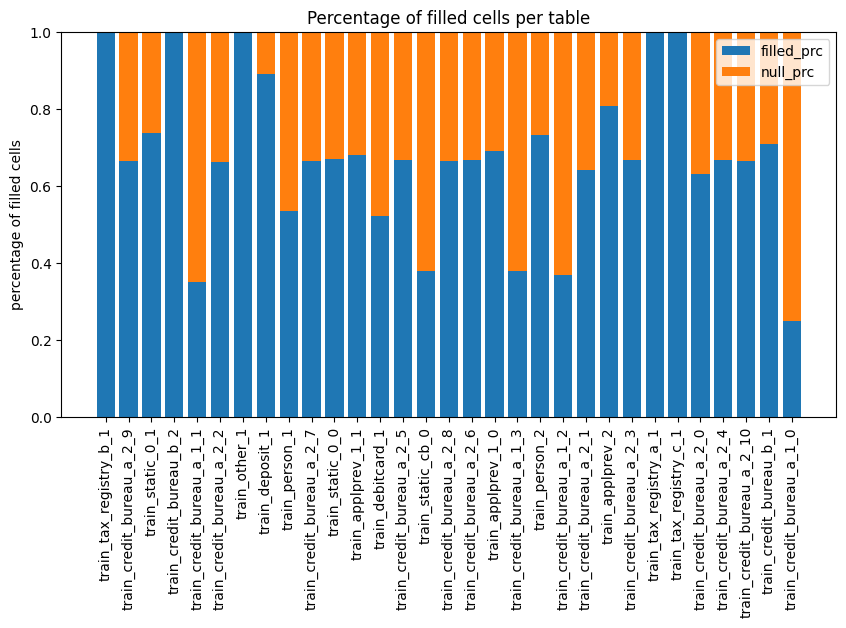

In [21]:
null_prc = df_nulls.select(['file', 'nulls_numb']).group_by('file').sum() \
                   .join(df_shapes.select(['file','cells_numb']).group_by('file').sum(), on='file') \
                   .with_columns((pl.col('nulls_numb')/pl.col('cells_numb')).alias('null_prc')) \
                   .with_columns((1-pl.col('null_prc')).alias('filled_prc'))

tot_nulls = (null_prc.select("nulls_numb").sum()/null_prc.select("cells_numb").sum())['nulls_numb'][0]

print(f'total number of null cells - {tot_nulls:.1%}, hence filled cells - {1-tot_nulls:.1%}')


plt.figure(figsize=(10, 5))
plt.bar(null_prc['file'], null_prc['filled_prc'], label='filled_prc')
plt.bar(null_prc['file'], null_prc['null_prc'], bottom=null_prc['filled_prc'], label='null_prc')
plt.xticks(rotation=90)
plt.title('Percentage of filled cells per table')
plt.ylabel('percentage of filled cells')
plt.legend()
plt.show()

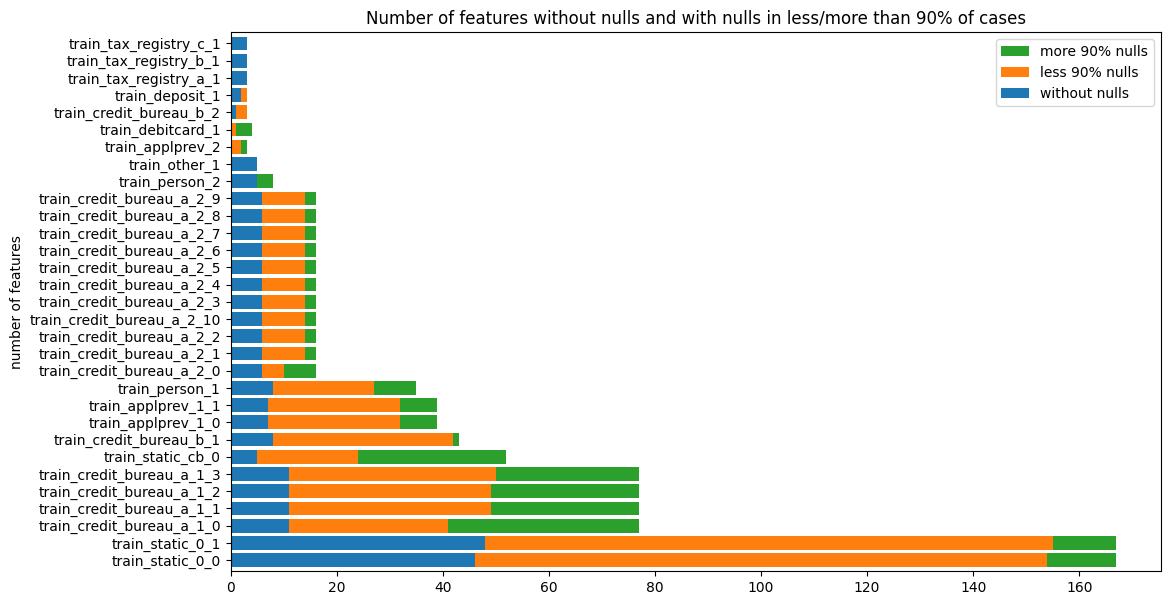

In [22]:
# fell free to change threshold - it's funny!
threshold_of_nulls = 0.9

nulls_prc_per_feat = df_nulls.join(df_shapes, on='file').with_columns((pl.col('nulls_numb')/pl.col('n')).alias('nulls_prc'))
ft_wo_nulls = nulls_prc_per_feat.filter(pl.col('nulls_numb')==0) \
                                .group_by('file').agg(pl.col('features').count().alias('without nulls'))
null_above_th = nulls_prc_per_feat.filter(pl.col('nulls_prc')>threshold_of_nulls) \
                                  .group_by('file').agg(pl.col('features').count().alias(f'more {threshold_of_nulls:.0%} nulls'))
null_below_th = nulls_prc_per_feat.filter((pl.col('nulls_prc')<threshold_of_nulls) & (pl.col('nulls_numb')>0)) \
                    .group_by('file').agg(pl.col('features').count().alias(f'less {threshold_of_nulls:.0%} nulls'))

df_pl = df_shapes.join(ft_wo_nulls, on='file', how='left') \
                 .join(null_above_th, on='file', how='left') \
                 .join(null_below_th, on='file', how='left') \
                 .fill_null(strategy='zero').sort('m', descending=True)

df_pl_pd = df_pl.to_pandas()
plt.figure(figsize=(12, 7))
df_pl_pd.plot.barh(x='file',
                   y=['without nulls', f'less {threshold_of_nulls:.0%} nulls', f'more {threshold_of_nulls:.0%} nulls'],
                   stacked=True,
                   legend='reverse',
                   title=f'Number of features without nulls and with nulls in less/more than {threshold_of_nulls:.0%} of cases',
                   ylabel='number of features',
                   width=0.8,
                   ax=plt.gca()
                  )
plt.show()

In [23]:
from polars import count

df_nulls.pivot(index='type', columns='dtypes', values='nulls_numb', aggregate_function=count())

shape: (6, 4)
┌──────┬─────────┬──────┬─────────┐
│ type ┆ Float64 ┆ Utf8 ┆ Boolean │
│ ---  ┆     --- ┆  --- ┆     --- │
│ str  ┆     u32 ┆  u32 ┆     u32 │
╞══════╪═════════╪══════╪═════════╡
│ P    ┆      83 ┆ null ┆    null │
│ A    ┆     236 ┆ null ┆    null │
│ D    ┆    null ┆  115 ┆    null │
│ L    ┆     303 ┆   46 ┆      21 │
│ M    ┆    null ┆  171 ┆    null │
│ T    ┆      81 ┆    5 ┆    null │
└──────┴─────────┴──────┴─────────┘

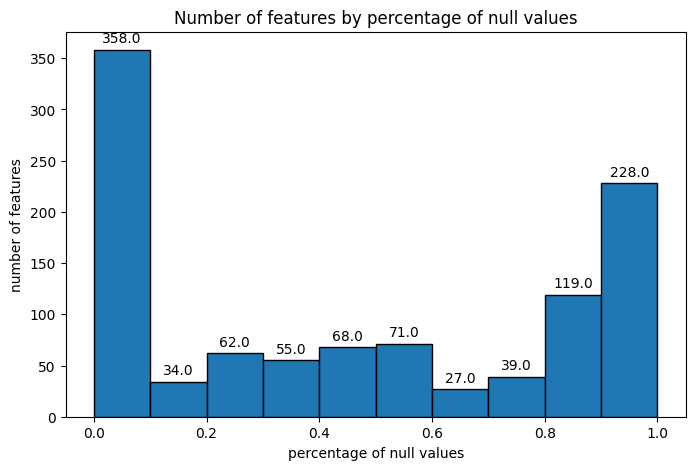

In [24]:
nulls_prc_per_feat_pd = nulls_prc_per_feat.to_pandas()

plt.figure(figsize=(8, 5))
ax = nulls_prc_per_feat_pd['nulls_prc'].plot.hist(bins=10, edgecolor='black')
for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{height}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')
plt.title('Number of features by percentage of null values')
plt.xlabel('percentage of null values')
plt.ylabel('number of features')
plt.show()


Now we've learned that our dataset is 40% empty！！！

# Base Table

In [44]:
df_train_base = pl.read_parquet('/content/drive/MyDrive/home-credit-credit-risk-model-stability/parquet_files/train/train_base.parquet')


df_train_base = df_train_base.with_columns(
    pl.col('date_decision').str.to_datetime(),
)

In [45]:
display(df_train_base.head())


shape: (5, 5)
┌─────────┬─────────────────────┬─────────┬──────────┬────────┐
│ case_id ┆ date_decision       ┆   MONTH ┆ WEEK_NUM ┆ target │
│     --- ┆ ---                 ┆     --- ┆      --- ┆    --- │
│     i64 ┆ datetime[μs]        ┆     i64 ┆      i64 ┆    i64 │
╞═════════╪═════════════════════╪═════════╪══════════╪════════╡
│       0 ┆ 2019-01-03 00:00:00 ┆ 201 901 ┆        0 ┆      0 │
│       1 ┆ 2019-01-03 00:00:00 ┆ 201 901 ┆        0 ┆      0 │
│       2 ┆ 2019-01-04 00:00:00 ┆ 201 901 ┆        0 ┆      0 │
│       3 ┆ 2019-01-03 00:00:00 ┆ 201 901 ┆        0 ┆      0 │
│       4 ┆ 2019-01-04 00:00:00 ┆ 201 901 ┆        0 ┆      1 │
└─────────┴─────────────────────┴─────────┴──────────┴────────┘

In [46]:
display(df_train_base.describe())

shape: (9, 6)
┌────────────┬─────────────┬─────────────────────┬─────────────┬─────────────┬─────────────┐
│ describe   ┆     case_id ┆ date_decision       ┆       MONTH ┆    WEEK_NUM ┆      target │
│ ---        ┆         --- ┆ ---                 ┆         --- ┆         --- ┆         --- │
│ str        ┆         f64 ┆ str                 ┆         f64 ┆         f64 ┆         f64 │
╞════════════╪═════════════╪═════════════════════╪═════════════╪═════════════╪═════════════╡
│ count      ┆ 1 526 659.0 ┆ 1526659             ┆ 1 526 659.0 ┆ 1 526 659.0 ┆ 1 526 659.0 │
│ null_count ┆         0.0 ┆ 0                   ┆         0.0 ┆         0.0 ┆         0.0 │
│ mean       ┆ 1 286 076.6 ┆ null                ┆   201 936.3 ┆        40.8 ┆         0.0 │
│ std        ┆   718 946.6 ┆ null                ┆        44.7 ┆        23.8 ┆         0.2 │
│ min        ┆         0.0 ┆ 2019-01-01 00:00:00 ┆   201 901.0 ┆         0.0 ┆         0.0 │
│ 25%        ┆   766 198.0 ┆ null                ┆   201 906.0 ┆        23.0 ┆         0.0 │
│ 50%        ┆ 1 357 358.0 ┆ null                ┆   201 910.0 ┆        40.0 ┆         0.0 │
│ 75%        ┆ 1 739 023.0 ┆ null                ┆   202 001.0 ┆        55.0 ┆         0.0 │
│ max        ┆ 2 703 454.0 ┆ 2020-10-05 00:00:00 ┆   202 010.0 ┆        91.0 ┆         1.0 │
└────────────┴─────────────┴─────────────────────┴─────────────┴─────────────┴─────────────┘

In [47]:
display(df_train_base['target'].value_counts())

shape: (2, 2)
┌────────┬─────────┐
│ target ┆   count │
│    --- ┆     --- │
│    i64 ┆     u32 │
╞════════╪═════════╡
│      0 ┆ 1478665 │
│      1 ┆   47994 │
└────────┴─────────┘

In [49]:
df_train_base = (
    pd
    .read_parquet('/content/drive/MyDrive/home-credit-credit-risk-model-stability/parquet_files/train/train_base.parquet')
)

In [50]:
value_counts = df_train_base['target'].value_counts()

relative_frequencies = value_counts / len(df_train_base)

result_df = pd.DataFrame({'count': value_counts, 'relative_frequency': relative_frequencies})

display(result_df)

count  relative_frequency
target                             
0       1478665            0.968563
1         47994            0.031437

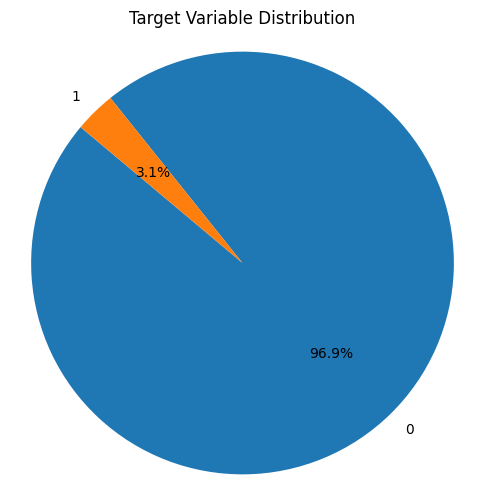

In [51]:
counts = df_train_base['target'].value_counts()
relative_frequencies = counts / len(df_train_base)

plt.figure(figsize=(6, 6))
plt.pie(relative_frequencies, labels=counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Target Variable Distribution')
plt.show()

The target is imbalanced. Only 3% of the entries have defaulted.

MONTH column is redundant. Indeed, year * 100 + month == MONTH.

In [52]:
df_train_base = pl.read_parquet('/content/drive/MyDrive/home-credit-credit-risk-model-stability/parquet_files/train/train_base.parquet')


df_train_base = df_train_base.with_columns(
    pl.col('date_decision').str.to_datetime(),
)

In [53]:
display(df_train_base.select(
    (
        pl.col('date_decision').dt.year() * 100 + pl.col('date_decision').dt.month()
         == pl.col('MONTH')
    ).all()))

shape: (1, 1)
┌───────────────┐
│ date_decision │
│ ---           │
│ bool          │
╞═══════════════╡
│ true          │
└───────────────┘

WEEK_NUM is also redundant. It is the week counting from 2019-01-01.

In [54]:
display(df_train_base.group_by('WEEK_NUM').agg(pl.col('date_decision').min()).sort('WEEK_NUM').head())

shape: (5, 2)
┌──────────┬─────────────────────┐
│ WEEK_NUM ┆ date_decision       │
│      --- ┆ ---                 │
│      i64 ┆ datetime[μs]        │
╞══════════╪═════════════════════╡
│        0 ┆ 2019-01-01 00:00:00 │
│        1 ┆ 2019-01-08 00:00:00 │
│        2 ┆ 2019-01-15 00:00:00 │
│        3 ┆ 2019-01-22 00:00:00 │
│        4 ┆ 2019-01-29 00:00:00 │
└──────────┴─────────────────────┘

In [55]:
display(df_train_base.select(
    (
        (pl.col('date_decision') - pl.date(2019, 1, 1)).dt.total_days() // 7
        == pl.col('WEEK_NUM')
    ).all()
))

shape: (1, 1)
┌───────────────┐
│ date_decision │
│ ---           │
│ bool          │
╞═══════════════╡
│ true          │
└───────────────┘

`case_id` is a unique identifier.

In [56]:
print(df_train_base['case_id'].n_unique() == len(df_train_base))

True


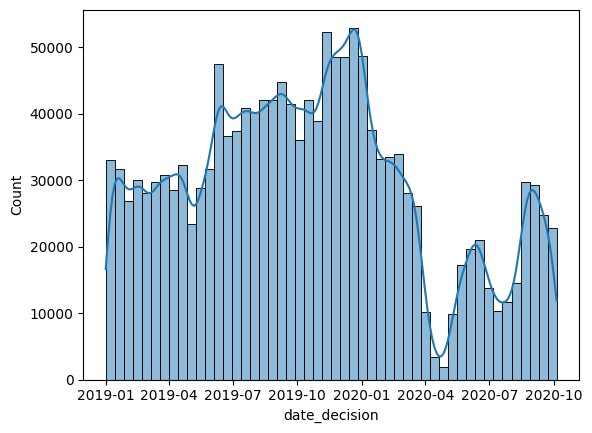

In [57]:
sns.histplot(x = df_train_base['date_decision'].to_pandas(),
             bins = 50,
             kde = True);

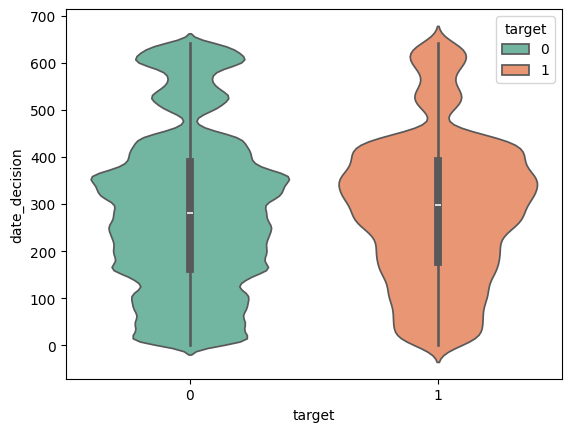

In [58]:

sns.violinplot(
    y=df_train_base.select((pl.col('date_decision') - pl.date(2019, 1, 1)).dt.total_days())['date_decision'].to_pandas(),
    x=df_train_base['target'].to_pandas(),
    hue=df_train_base['target'].to_pandas(),
    orient='v',
    palette='Set2'
);

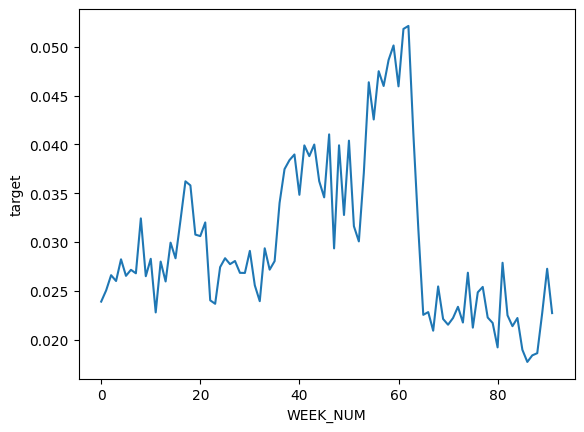

In [59]:
sns.lineplot(df_train_base.group_by('WEEK_NUM').agg(pl.col('target').mean()).to_pandas(),
             x = 'WEEK_NUM', y = 'target');

# static depth 0

In [25]:
df_train_static_0_0 = scan_data_and_parse_dates('/content/drive/MyDrive/home-credit-credit-risk-model-stability/parquet_files/train/train_static_0_0.parquet')
df_train_static_0_1 = scan_data_and_parse_dates('/content/drive/MyDrive/home-credit-credit-risk-model-stability/parquet_files/train/train_static_0_1.parquet')

In [26]:
print(df_train_static_0_0.schema == df_train_static_0_1.schema)

True


They have the same schema. So we may scan all tables of the same kind at the same time and concatenate them. pl.scan_parquet() does this job given a globbing pattern.

In [27]:
df_train_static_0 = scan_data_and_parse_dates('/content/drive/MyDrive/home-credit-credit-risk-model-stability/parquet_files/train/train_static_0_*.parquet')

In [29]:
with pl.Config() as cfg:
    cfg.set_tbl_cols(-1)
    display(df_train_static_0.head().collect())

shape: (5, 168)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ cas ┆ act ┆ amt ┆ ann ┆ ann ┆ app ┆ app ┆ app ┆ app ┆ app ┆ app ┆ avg ┆ avg ┆ avg ┆ avg ┆ avg ┆ avg ┆ avg ┆ avg ┆ avg ┆ ban ┆ car ┆ cli ┆ cli ┆ cli ┆ cli ┆ cli ┆ cli ┆ cli ┆ cli ┆ cli ┆ cli ┆ cli ┆ cli ┆ cli ┆ cli ┆ cli ┆ cli ┆ cnt ┆ cnt ┆ com ┆ cre ┆ cre ┆ cur ┆ cur ┆ dat ┆ dat ┆ dat ┆ day ┆ def ┆ dis ┆ dis ┆ dow ┆ dtl ┆ eir ┆ equ ┆ equ ┆ fir ┆ fir ┆ hom ┆ ini ┆ ini ┆ int ┆ int ┆ isb ┆ isb ┆ isd ┆ las ┆ las ┆ las ┆ las ┆ las ┆ las ┆ las ┆ las ┆ las ┆ las ┆ las ┆ las ┆ las ┆ las ┆ las ┆ las ┆ las ┆ las ┆ las ┆ mai ┆ mas ┆ mas ┆ max ┆ max ┆ max ┆ max ┆ max ┆ max ┆ max ┆ max ┆ max ┆ max ┆ max ┆ max ┆ max ┆ max ┆ max ┆ max ┆ max ┆ max ┆ max ┆ min ┆ min ┆ mob ┆ mon ┆ num ┆ num ┆ num ┆ num ┆ num ┆ num ┆ num ┆ num ┆ num ┆ num ┆ num ┆ num ┆ num ┆ num ┆ num ┆ num ┆ num ┆ num ┆ num ┆ num ┆ num ┆ num ┆ num ┆ num ┆ num ┆ num ┆ num ┆ num ┆ num ┆ num ┆ num ┆ ope ┆ pay ┆ pay ┆ pay ┆ pct ┆ pct ┆ pct ┆ pct ┆ pct ┆ pmt ┆ pos ┆ pos ┆ pos ┆ pre ┆ pri ┆ sel ┆ sel ┆ sum ┆ sum ┆ tot ┆ tot ┆ tot ┆ two ┆ typ ┆ val │
│ e_i ┆ ual ┆ ins ┆ uit ┆ uit ┆ lic ┆ lic ┆ lic ┆ lic ┆ lic ┆ lic ┆ dbd ┆ dbd ┆ dbd ┆ dpd ┆ ins ┆ lna ┆ max ┆ out ┆ pmt ┆ kac ┆ dty ┆ ent ┆ ent ┆ ent ┆ ent ┆ ent ┆ ent ┆ ent ┆ ent ┆ ent ┆ ent ┆ ent ┆ ent ┆ ent ┆ ent ┆ ent ┆ ent ┆ inc ┆ pmt ┆ mno ┆ dam ┆ dty ┆ rde ┆ rde ┆ efi ┆ ela ┆ ela ┆ sov ┆ err ┆ bur ┆ bur ┆ npm ┆ ast ┆ _27 ┆ ali ┆ ali ┆ stc ┆ std ┆ eph ┆ ttr ┆ ttr ┆ ere ┆ ere ┆ idp ┆ idp ┆ ebi ┆ tac ┆ tap ┆ tap ┆ tap ┆ tap ┆ tap ┆ tca ┆ tde ┆ tde ┆ tot ┆ tot ┆ tre ┆ tre ┆ tre ┆ tre ┆ tre ┆ tre ┆ tre ┆ tst ┆ nin ┆ ter ┆ ter ┆ ann ┆ ann ┆ dbd ┆ dbd ┆ dbd ┆ deb ┆ dpd ┆ dpd ┆ dpd ┆ dpd ┆ dpd ┆ dpd ┆ dpd ┆ dpd ┆ dpd ┆ ins ┆ lna ┆ out ┆ pmt ┆ dbd ┆ dbd ┆ ile ┆ ths ┆ act ┆ act ┆ act ┆ con ┆ inc ┆ ins ┆ ins ┆ ins ┆ ins ┆ ins ┆ ins ┆ ins ┆ ins ┆ ins ┆ ins ┆ ins ┆ ins ┆ ins ┆ ins ┆ ins ┆ ins ┆ ins ┆ ins ┆ ins ┆ ins ┆ ins ┆ ins ┆ ins ┆ not ┆ pmt ┆ rej ┆ ncr ┆ typ ┆ typ ┆ vac ┆ ins ┆ ins ┆ ins ┆ ins ┆ ins ┆ num ┆ fpd ┆ fpd ┆ fst ┆ vio ┆ ce_ ┆ ler ┆ ler ┆ out ┆ out ┆ ald ┆ als ┆ ins ┆ bod ┆ esu ┆ idf │
│   d ┆ dpd ┆ tpa ┆ y_7 ┆ yne ┆ ati ┆ ati ┆ ati ┆ ati ┆ ati ┆ ati ┆ dpd ┆ dpd ┆ tol ┆ tol ┆ tal ┆ mts ┆ dpd ┆ sta ┆ las ┆ cty ┆ pe_ ┆ scn ┆ scn ┆ scn ┆ scn ┆ scn ┆ scn ┆ scn ┆ scn ┆ scn ┆ scn ┆ scn ┆ scn ┆ scn ┆ scn ┆ scn ┆ scn ┆ pay ┆ s24 ┆ inc ┆ oun ┆ pe_ ┆ bt_ ┆ btc ┆ rst ┆ sti ┆ stu ┆ erd ┆ edm ┆ sed ┆ sem ┆ t_1 ┆ pmt ┆  0L ┆ tyd ┆ tye ┆ lxc ┆ ate ┆ ncn ┆ ans ┆ ans ┆ str ┆ str ┆ rod ┆ rod ┆ tca ┆ tiv ┆ pli ┆ prc ┆ prc ┆ prc ┆ prd ┆ nce ┆ lin ┆ pen ┆ her ┆ her ┆ jec ┆ jec ┆ jec ┆ jec ┆ jec ┆ jec ┆ pay ┆ _73 ┆ c_2 ┆ con ┆ con ┆ uit ┆ uit ┆ dpd ┆ dpd ┆ dpd ┆ t4_ ┆ fro ┆ ins ┆ ins ┆ las ┆ las ┆ las ┆ las ┆ las ┆ tol ┆ tal ┆ mts ┆ sta ┆ las ┆ dpd ┆ tol ┆ phn ┆ ann ┆ ive ┆ ive ┆ ive ┆ trs ┆ omi ┆ tla ┆ tls ┆ tls ┆ tls ┆ tls ┆ tls ┆ tma ┆ tpa ┆ tpa ┆ tpa ┆ tpa ┆ tpa ┆ tpa ┆ tpa ┆ tpa ┆ tpa ┆ tpa ┆ tre ┆ tre ┆ tto ┆ tto ┆ tun ┆ tun ┆ act ┆ cha ┆ ect ┆ ed_ ┆ e1s ┆ e_7 ┆ ati ┆ tls ┆ tls ┆ tls ┆ tls ┆ tls ┆ _25 ┆ 10l ┆ 30l ┆ qpd ┆ usc ┆ 109 ┆ pla 

In [28]:
with pl.Config() as cfg:
    cfg.set_fmt_str_lengths(200)
    cfg.set_tbl_rows(-1)
    display(get_feature_definitions(df_train_static_0.columns))

shape: (168, 2)
┌─────────────────────────────────┬────────────────────────────────────────────────────────────────┐
│ Variable                        ┆ Description                                                    │
│ ---                             ┆ ---                                                            │
│ str                             ┆ str                                                            │
╞═════════════════════════════════╪════════════════════════════════════════════════════════════════╡
│ case_id                         ┆ null                                                           │
│ actualdpdtolerance_344P         ┆ DPD of client with tolerance.                                  │
│ amtinstpaidbefduel24m_4187115A  ┆ Number of instalments paid before due date in the last 24      │
│                                 ┆ months.                                                        │
│ annuity_780A                    ┆ Monthly annuity amount.                                        │
│ annuitynextmonth_57A            ┆ Next month's amount of annuity.                                │
│ applicationcnt_361L             ┆ Number of applications associated with the same email address  │
│                                 ┆ as the client.                                                 │
│ applications30d_658L            ┆ Number of applications made by the client in the last 30 days. │
│ applicationscnt_1086L           ┆ Number of applications associated with the same phone number.  │
│ applicationscnt_464L            ┆ Number of applications made in the last 30 days by other       │
│                                 ┆ clients with the same employer as the applicant.               │
│ applicationscnt_629L            ┆ Number of applications with the same employer in the last 7    │
│                                 ┆ days.                                                          │
│ applicationscnt_867L            ┆ Number of applications associated with the same mobile phone.  │
│ avgdbddpdlast24m_3658932P       ┆ Average days past or before due of payment during the last 24  │
│                                 ┆ months.                                                        │
│ avgdbddpdlast3m_4187120P        ┆ Average days past or before due of payment during the last 3   │
│                                 ┆ months.                                                        │
│ avgdbdtollast24m_4525197P       ┆ Average days of payment before due date within the last 24     │
│                                 ┆ months (with tolerance).                                       │
│ avgdpdtolclosure24_3658938P     ┆ Average DPD (days past due) with tolerance within the past 24  │
│                                 ┆ months from the maximum closure date, assuming that the        │
│                                 ┆ contract is finished. If the contract is ongoing, the          │
│                                 ┆ calculation is based on the …                                  │
│ avginstallast24m_3658937A       ┆ Average instalments paid by the client over the past 24        │
│                                 ┆ months.                                                        │
│ avglnamtstart24m_4525187A       ┆ Average loan amount in the last 24 months.                     │
│ avgmaxdpdlast9m_3716943P        ┆ Average Days Past Due (DPD) of the client in last 9 months.    │
│ avgoutstandbalancel6m_4187114A  ┆ Average outstanding balance of applicant for the last 6        │
│                                 ┆ months.                                                        │
│ avgpmtlast12m_4525200A          ┆ Average of payments made by the client in the last 12 months.  │
│ bankacctype_710L                ┆ Type of applicant's bank account.                              │
│ cardtype_51L                    ┆ Type of credit card.                                           │
│ clientscnt12m_3712952L          ┆ Number of

In [30]:
with pl.Config() as cfg:
    cfg.set_tbl_cols(-1)
    description = df_train_static_0.select(cs.by_dtype(pl.NUMERIC_DTYPES, pl.Datetime)).collect().describe().to_pandas().transpose()
    description.rename(columns={0: 'Count', 1: 'Null Count', 2: 'Mean', 3: 'Std', 4: 'Min', 5: '25%', 6: '50%', 7: '75%', 8: 'Max'}, inplace=True)
    display(description)


Count  Null Count            Mean  \
describe                            count  null_count            mean   
case_id                         1526659.0         0.0  1286076.571739   
actualdpdtolerance_344P         1108481.0    418178.0        0.079234   
amtinstpaidbefduel24m_4187115A   965535.0    561124.0    55958.330289   
annuity_780A                    1526659.0         0.0     4039.207272   
...                                   ...         ...             ...   
sumoutstandtotalest_4493215A     686013.0    840646.0    28309.736702   
totaldebt_9A                    1526656.0         3.0    19683.115099   
totalsettled_863A               1526655.0         4.0     92238.16935   
totinstallast1m_4525188A         352448.0   1174211.0    10411.377565   
validfrom_1069D                    151773     1374886            None   

                                          Std                  Min       25%  \
describe                                  std                  min       25%   
case_id                         718946.592285                  0.0  766198.0   
actualdpdtolerance_344P             11.206518                  0.0       0.0   
amtinstpaidbefduel24m_4187115A   71614.166354                  0.0    7419.2   
annuity_780A                      3006.607629                 80.8    1967.6   
...                                       ...                  ...       ...   
sumoutstandtotalest_4493215A     60500.097619             -25044.0       0.0   
totaldebt_9A                     50836.034256                  0.0       0.0   
totalsettled_863A               162335.779968                  0.0       0.0   
totinstallast1m_4525188A         16222.912082                0.214  3309.352   
validfrom_1069D                          None  2018-09-22 00:00:00      None   

                                      50%        75%                  Max  
describe                              50%        75%                  max  
case_id                         1357358.0  1739023.0            2703454.0  
actualdpdtolerance_344P               0.0        0.0               4206.0  
amtinstpaidbefduel24m_4187115A  29758.396  76303.086            1408010.2  
annuity_780A                       3151.8     5231.4             106007.0  
...                                   ...        ...                  ...  
sumoutstandtotalest_4493215A          0.0    27984.0            1085048.1  
totaldebt_9A                          0.0    13493.0            1210629.1  
totalsettled_863A               35977.664   118816.0           48035036.0  
totinstallast1m_4525188A           6221.2    11685.0             794899.2  
validfrom_1069D                      None       None  2020-06-22 00:00:00  

[145 rows x 9 columns]

In [31]:
display(df_train_static_0.select(cs.by_dtype(pl.Utf8).n_unique()).collect())
#计算 df_train_static_0 中所有字符串类型列的唯一值数量

shape: (1, 18)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ bankaccty ┆ cardtype_ ┆ credtype_ ┆ disbursem ┆ … ┆ paytype_7 ┆ previousc ┆ twobodfil ┆ typesuit │
│   pe_710L ┆       51L ┆      322L ┆ enttype_6 ┆   ┆       83L ┆ ontdistri ┆ ling_608L ┆   e_864L │
│       --- ┆       --- ┆       --- ┆        7L ┆   ┆       --- ┆   ct_112M ┆       --- ┆      --- │
│       u32 ┆       u32 ┆       u32 ┆       --- ┆   ┆       u32 ┆       --- ┆       u32 ┆      u32 │
│           ┆           ┆           ┆       u32 ┆   ┆           ┆       u32 ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│         2 ┆         3 ┆         4 ┆         4 ┆ … ┆         2 ┆       223 ┆         3 ┆        2 │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

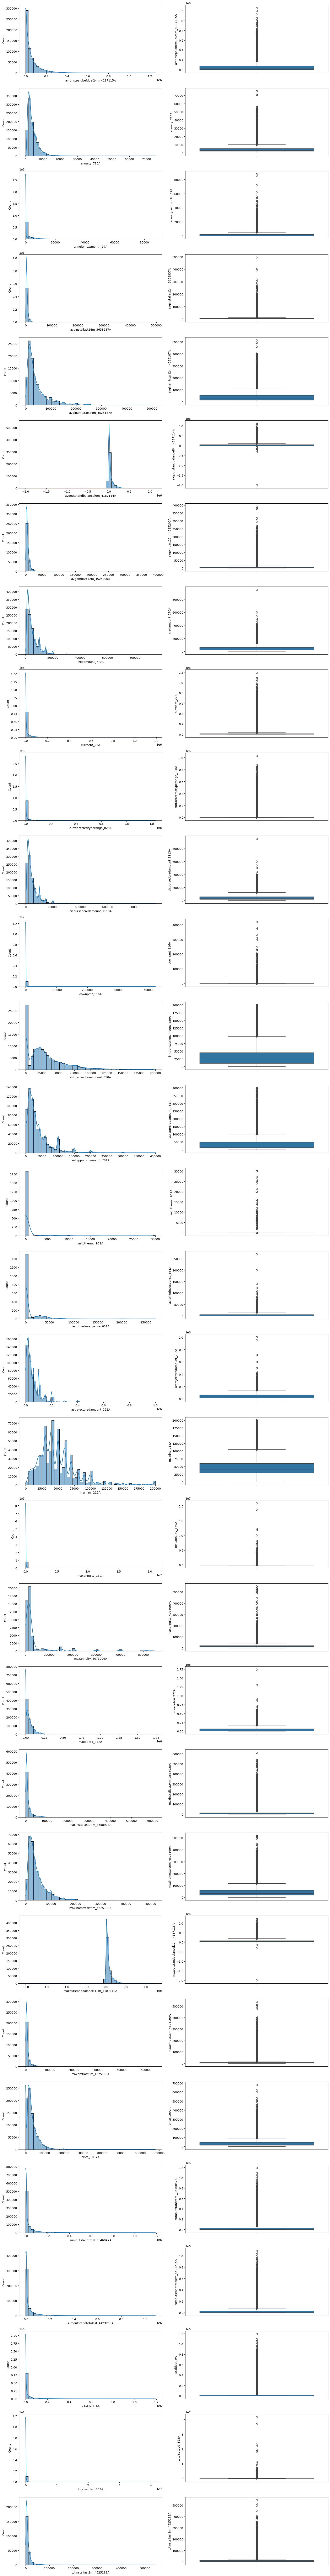

In [32]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plot_numerical(df_train_static_0, 'A')

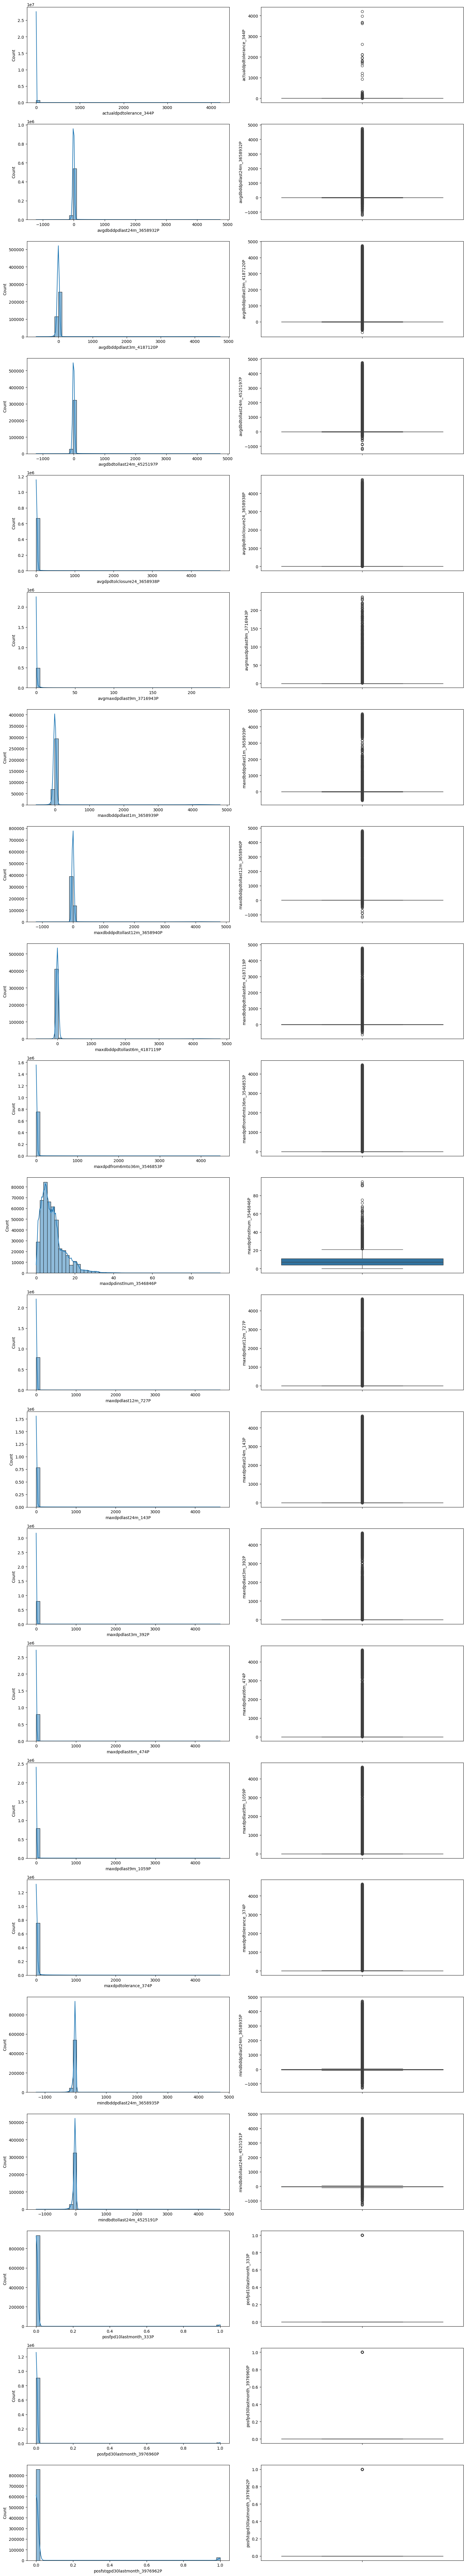

In [33]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plot_numerical(df_train_static_0, 'P')

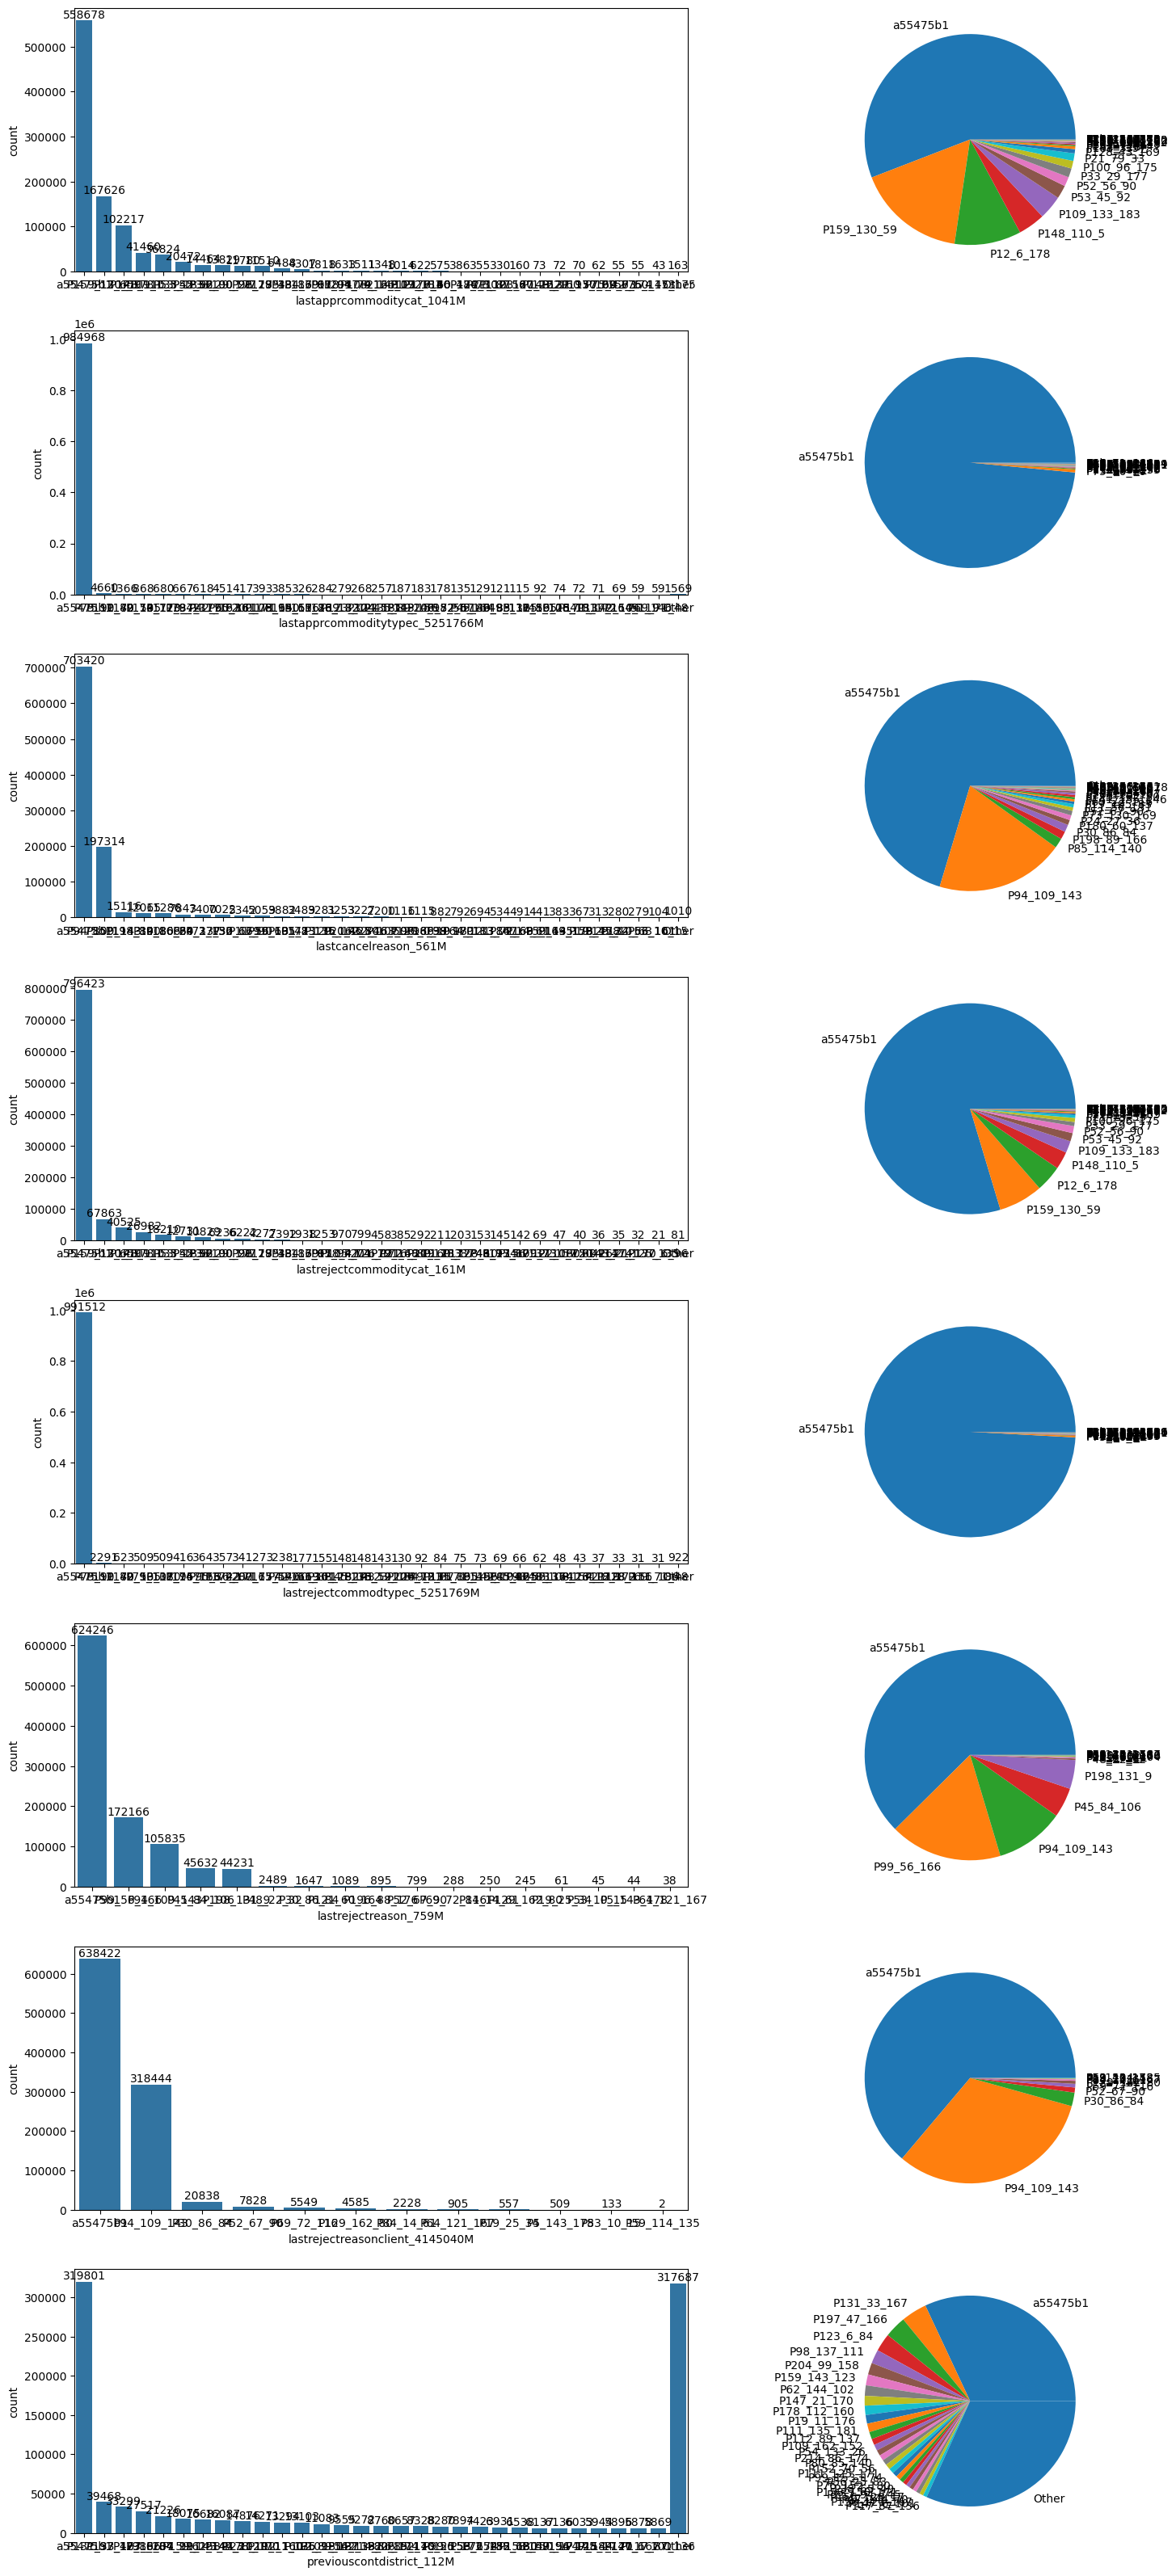

In [34]:
plot_categorical(df_train_static_0, 'M')

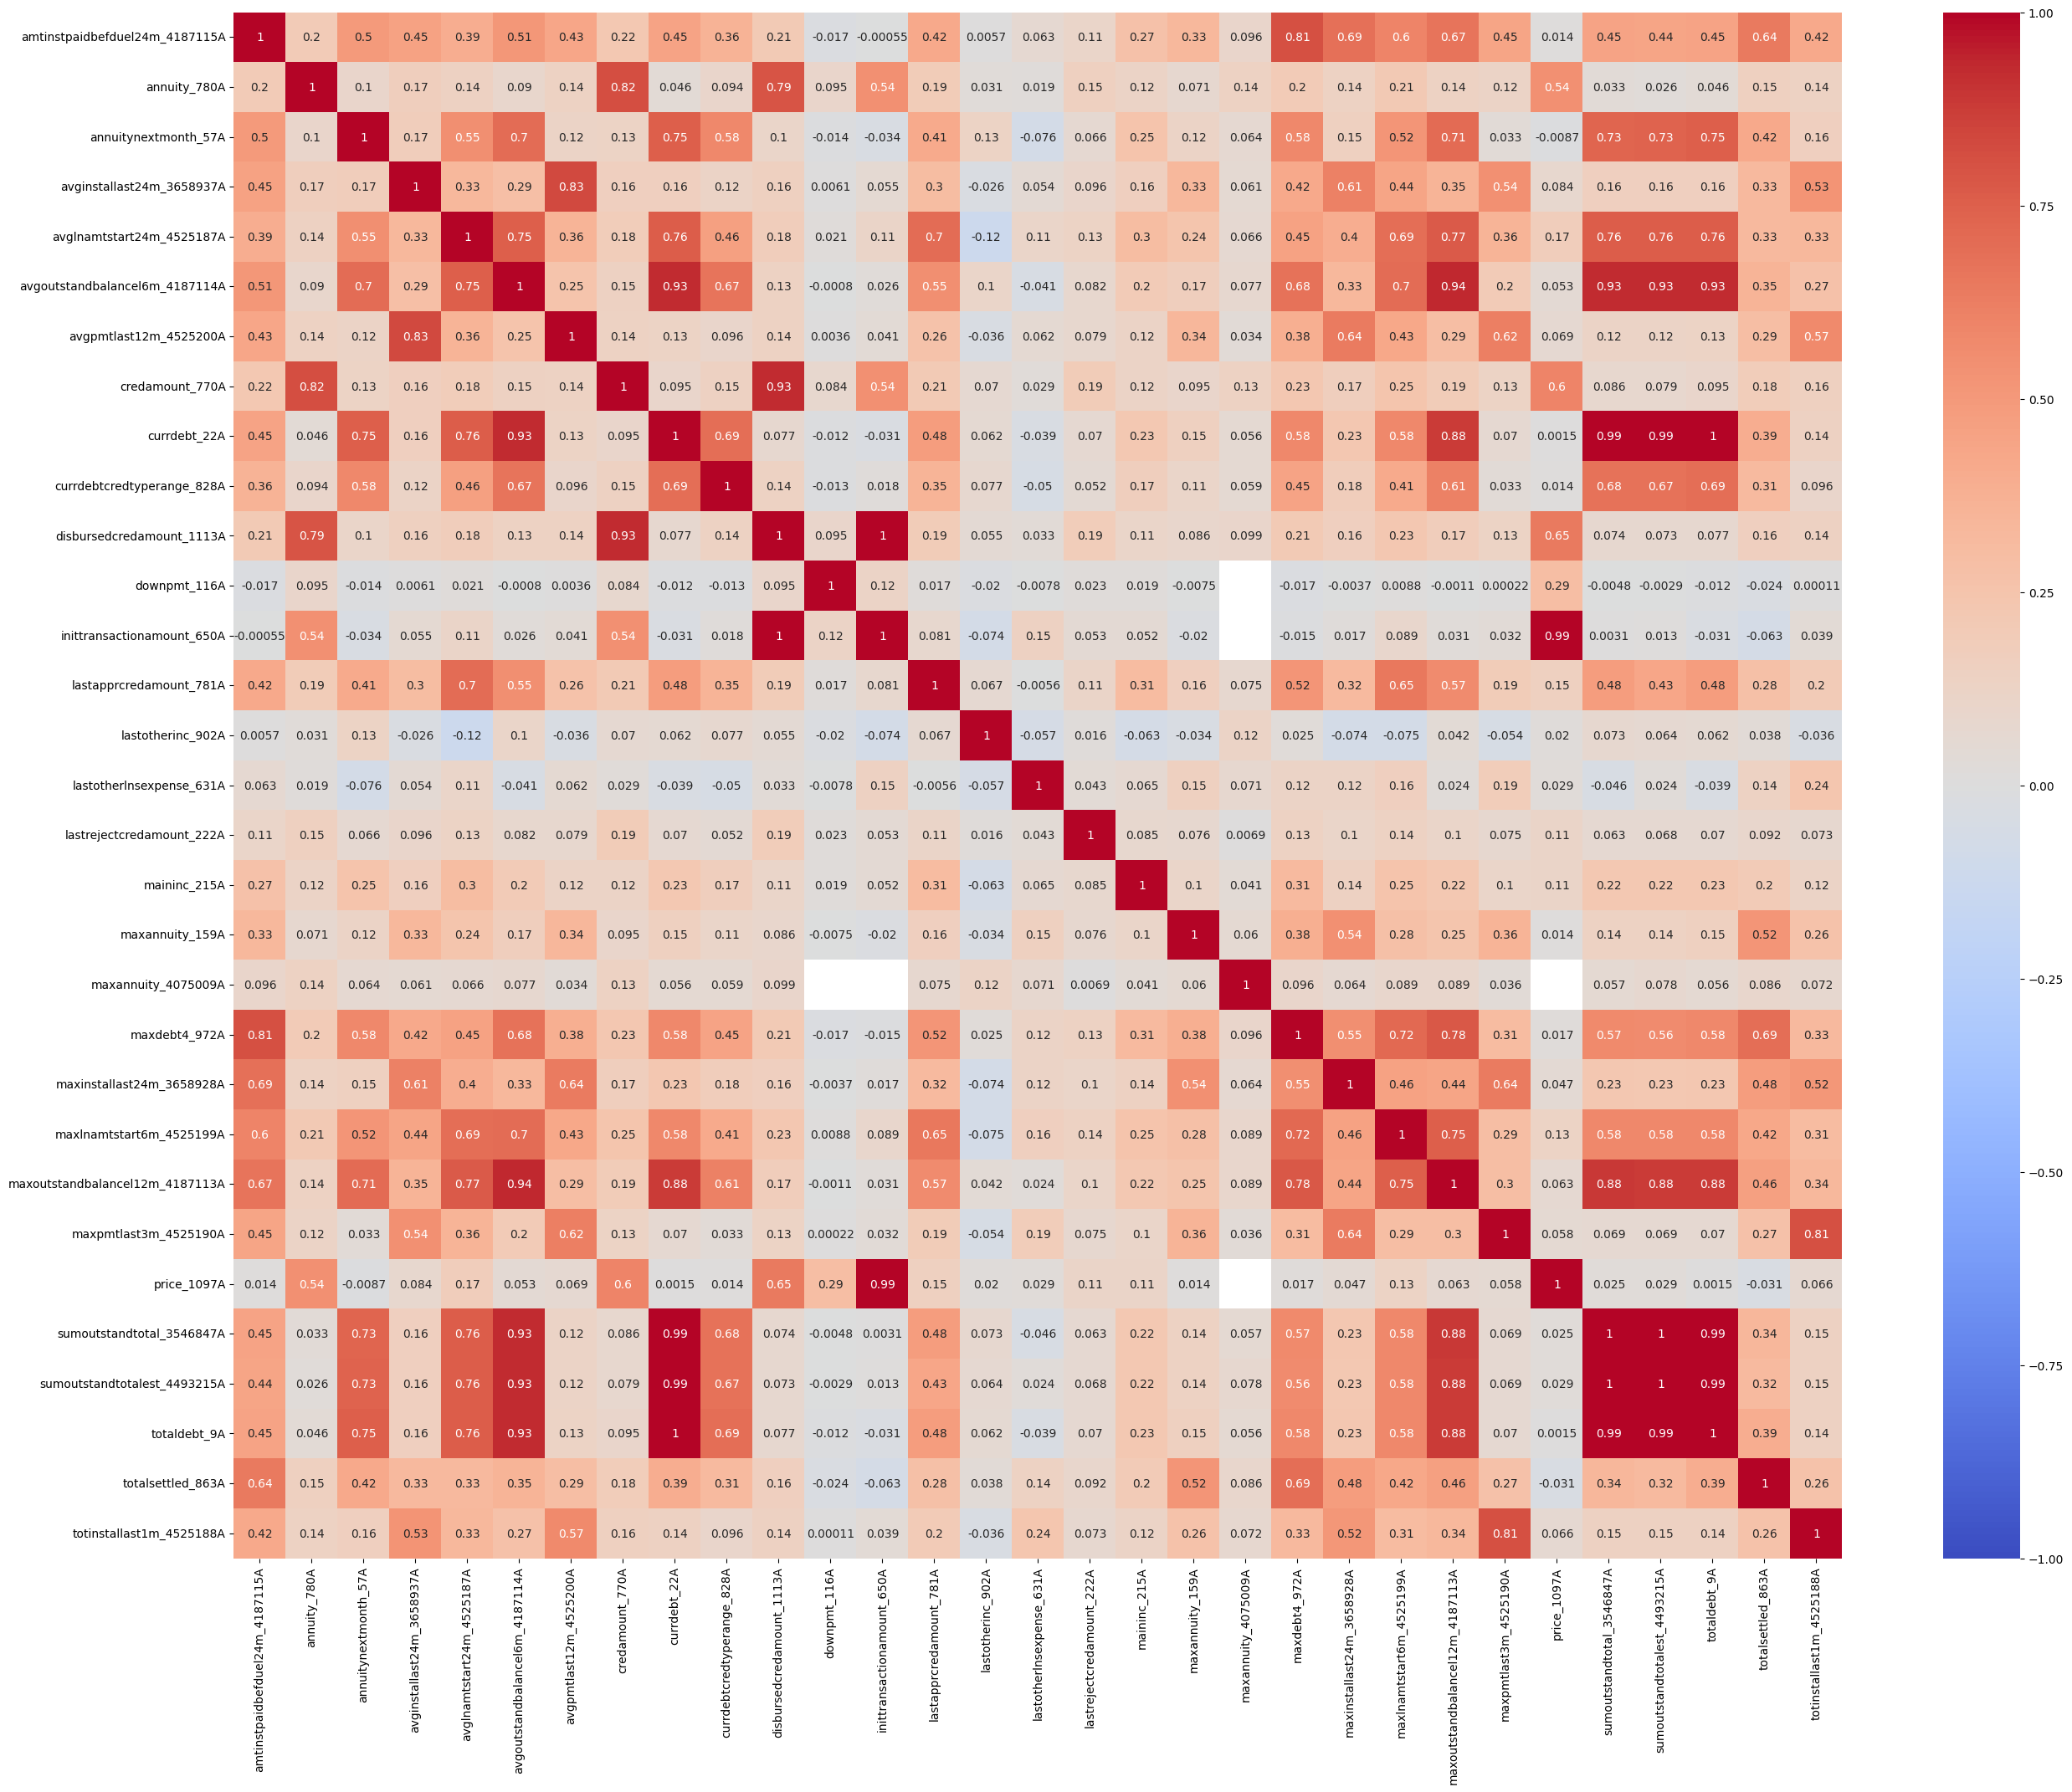

In [35]:
plot_corr(df_train_static_0, 'A')

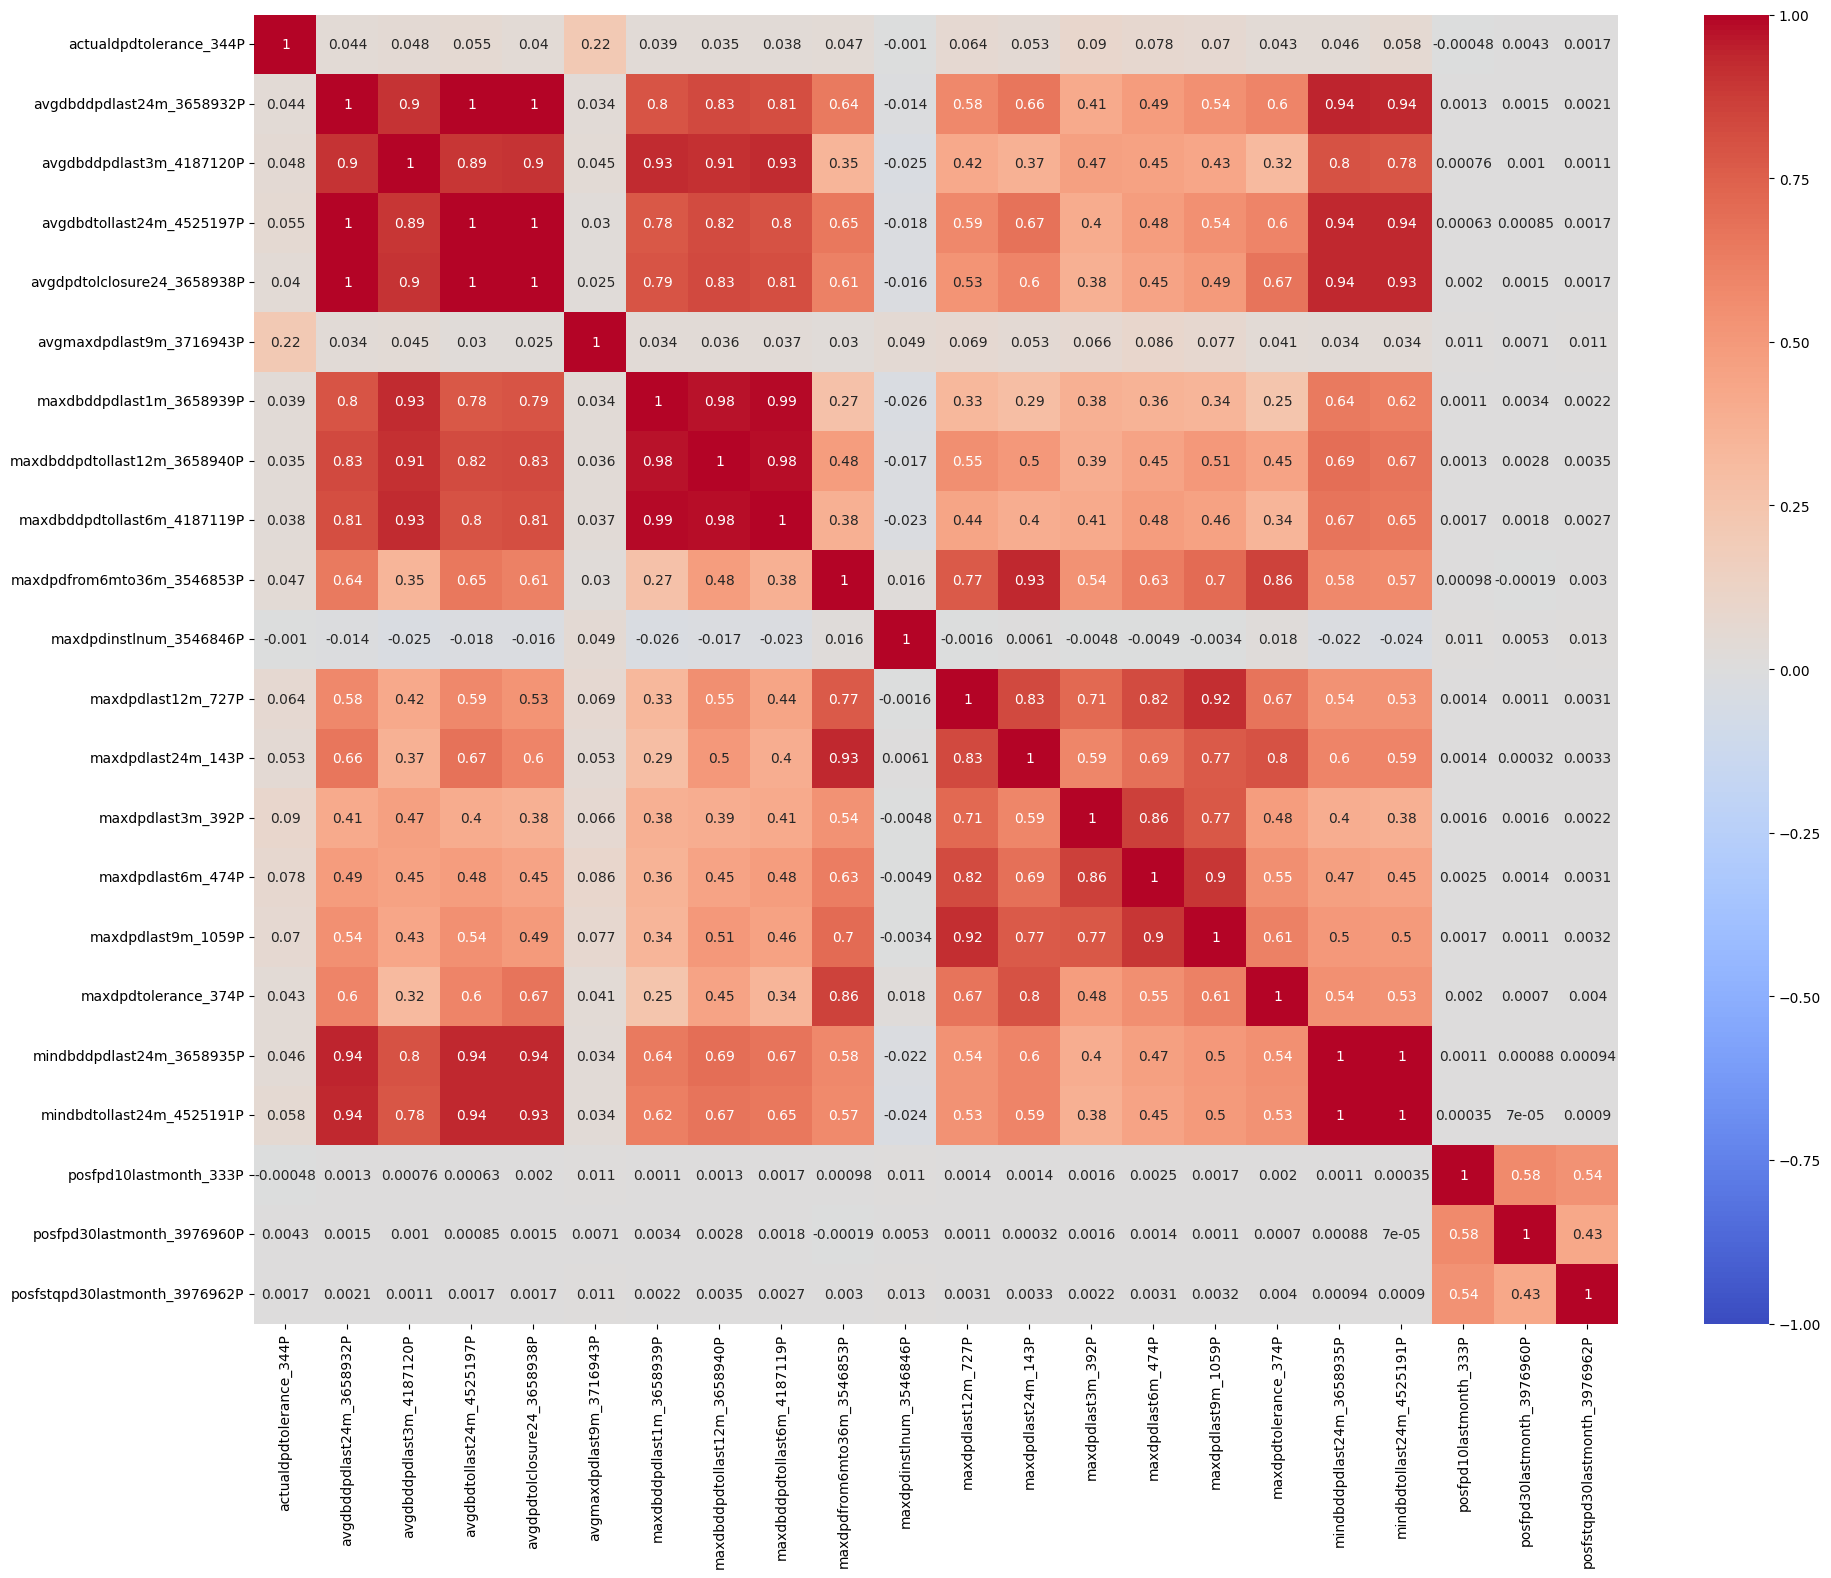

In [36]:
plot_corr(df_train_static_0, 'P')

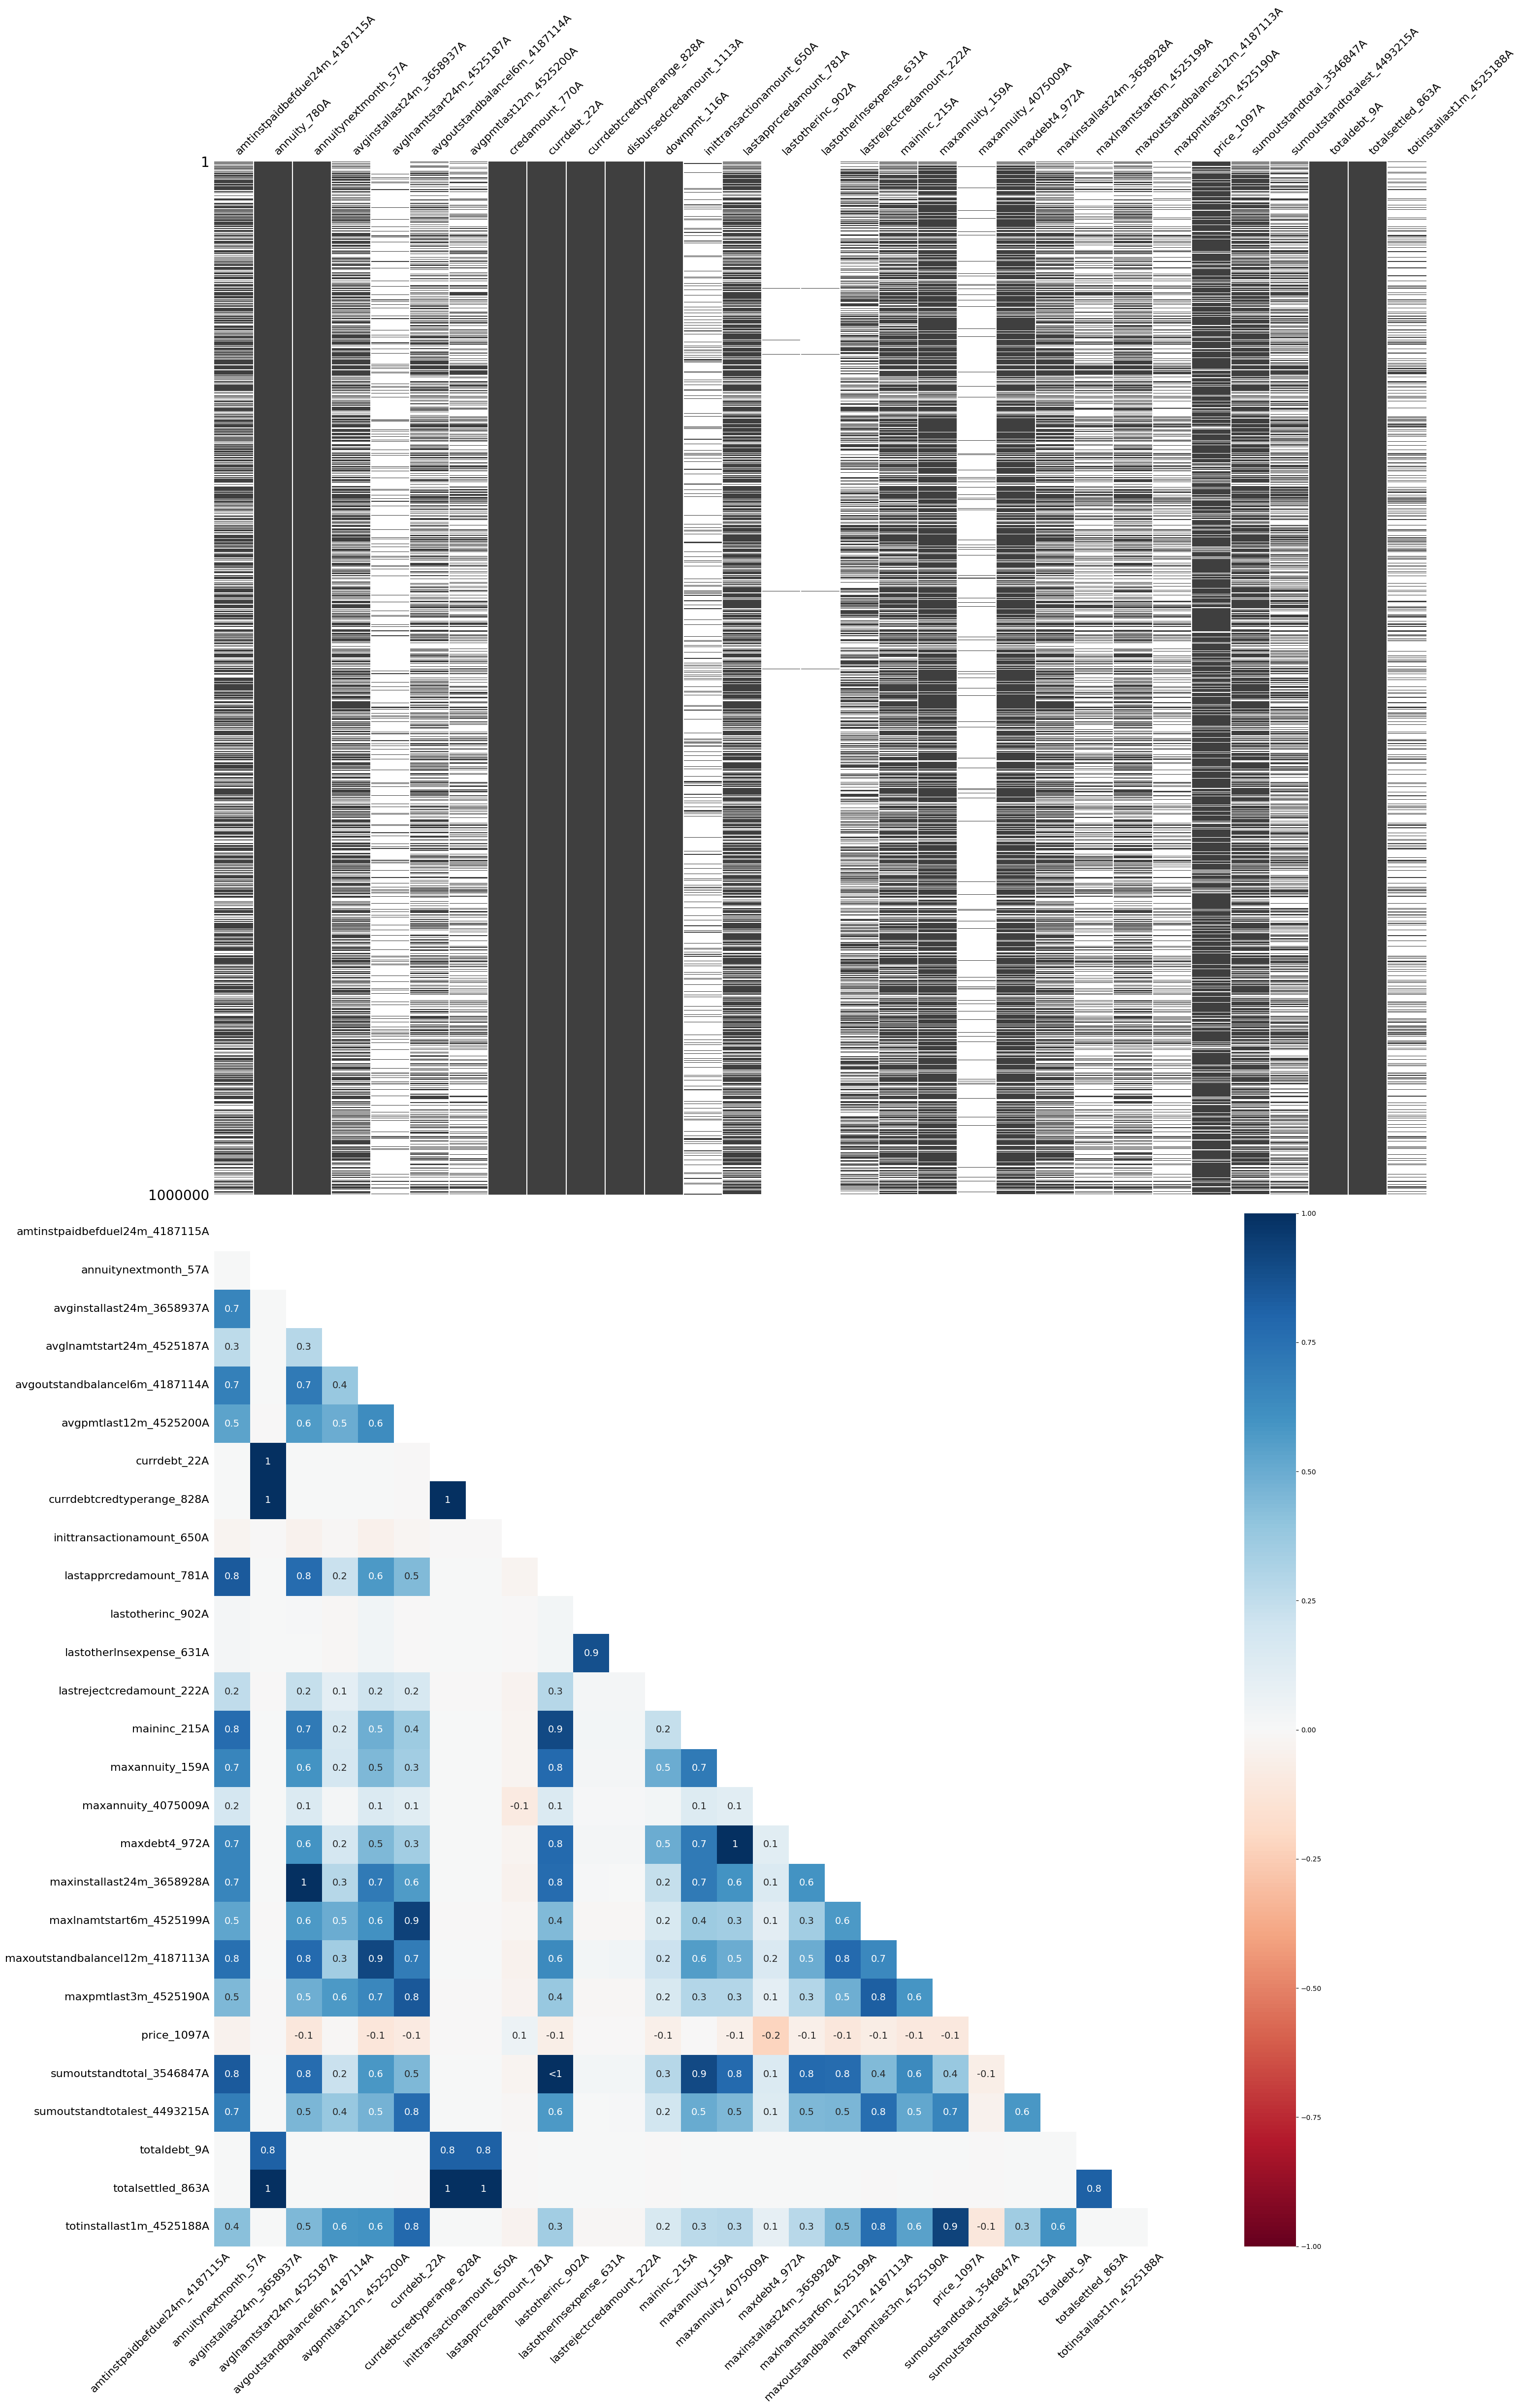

In [37]:
plot_null(df_train_static_0, 'A')

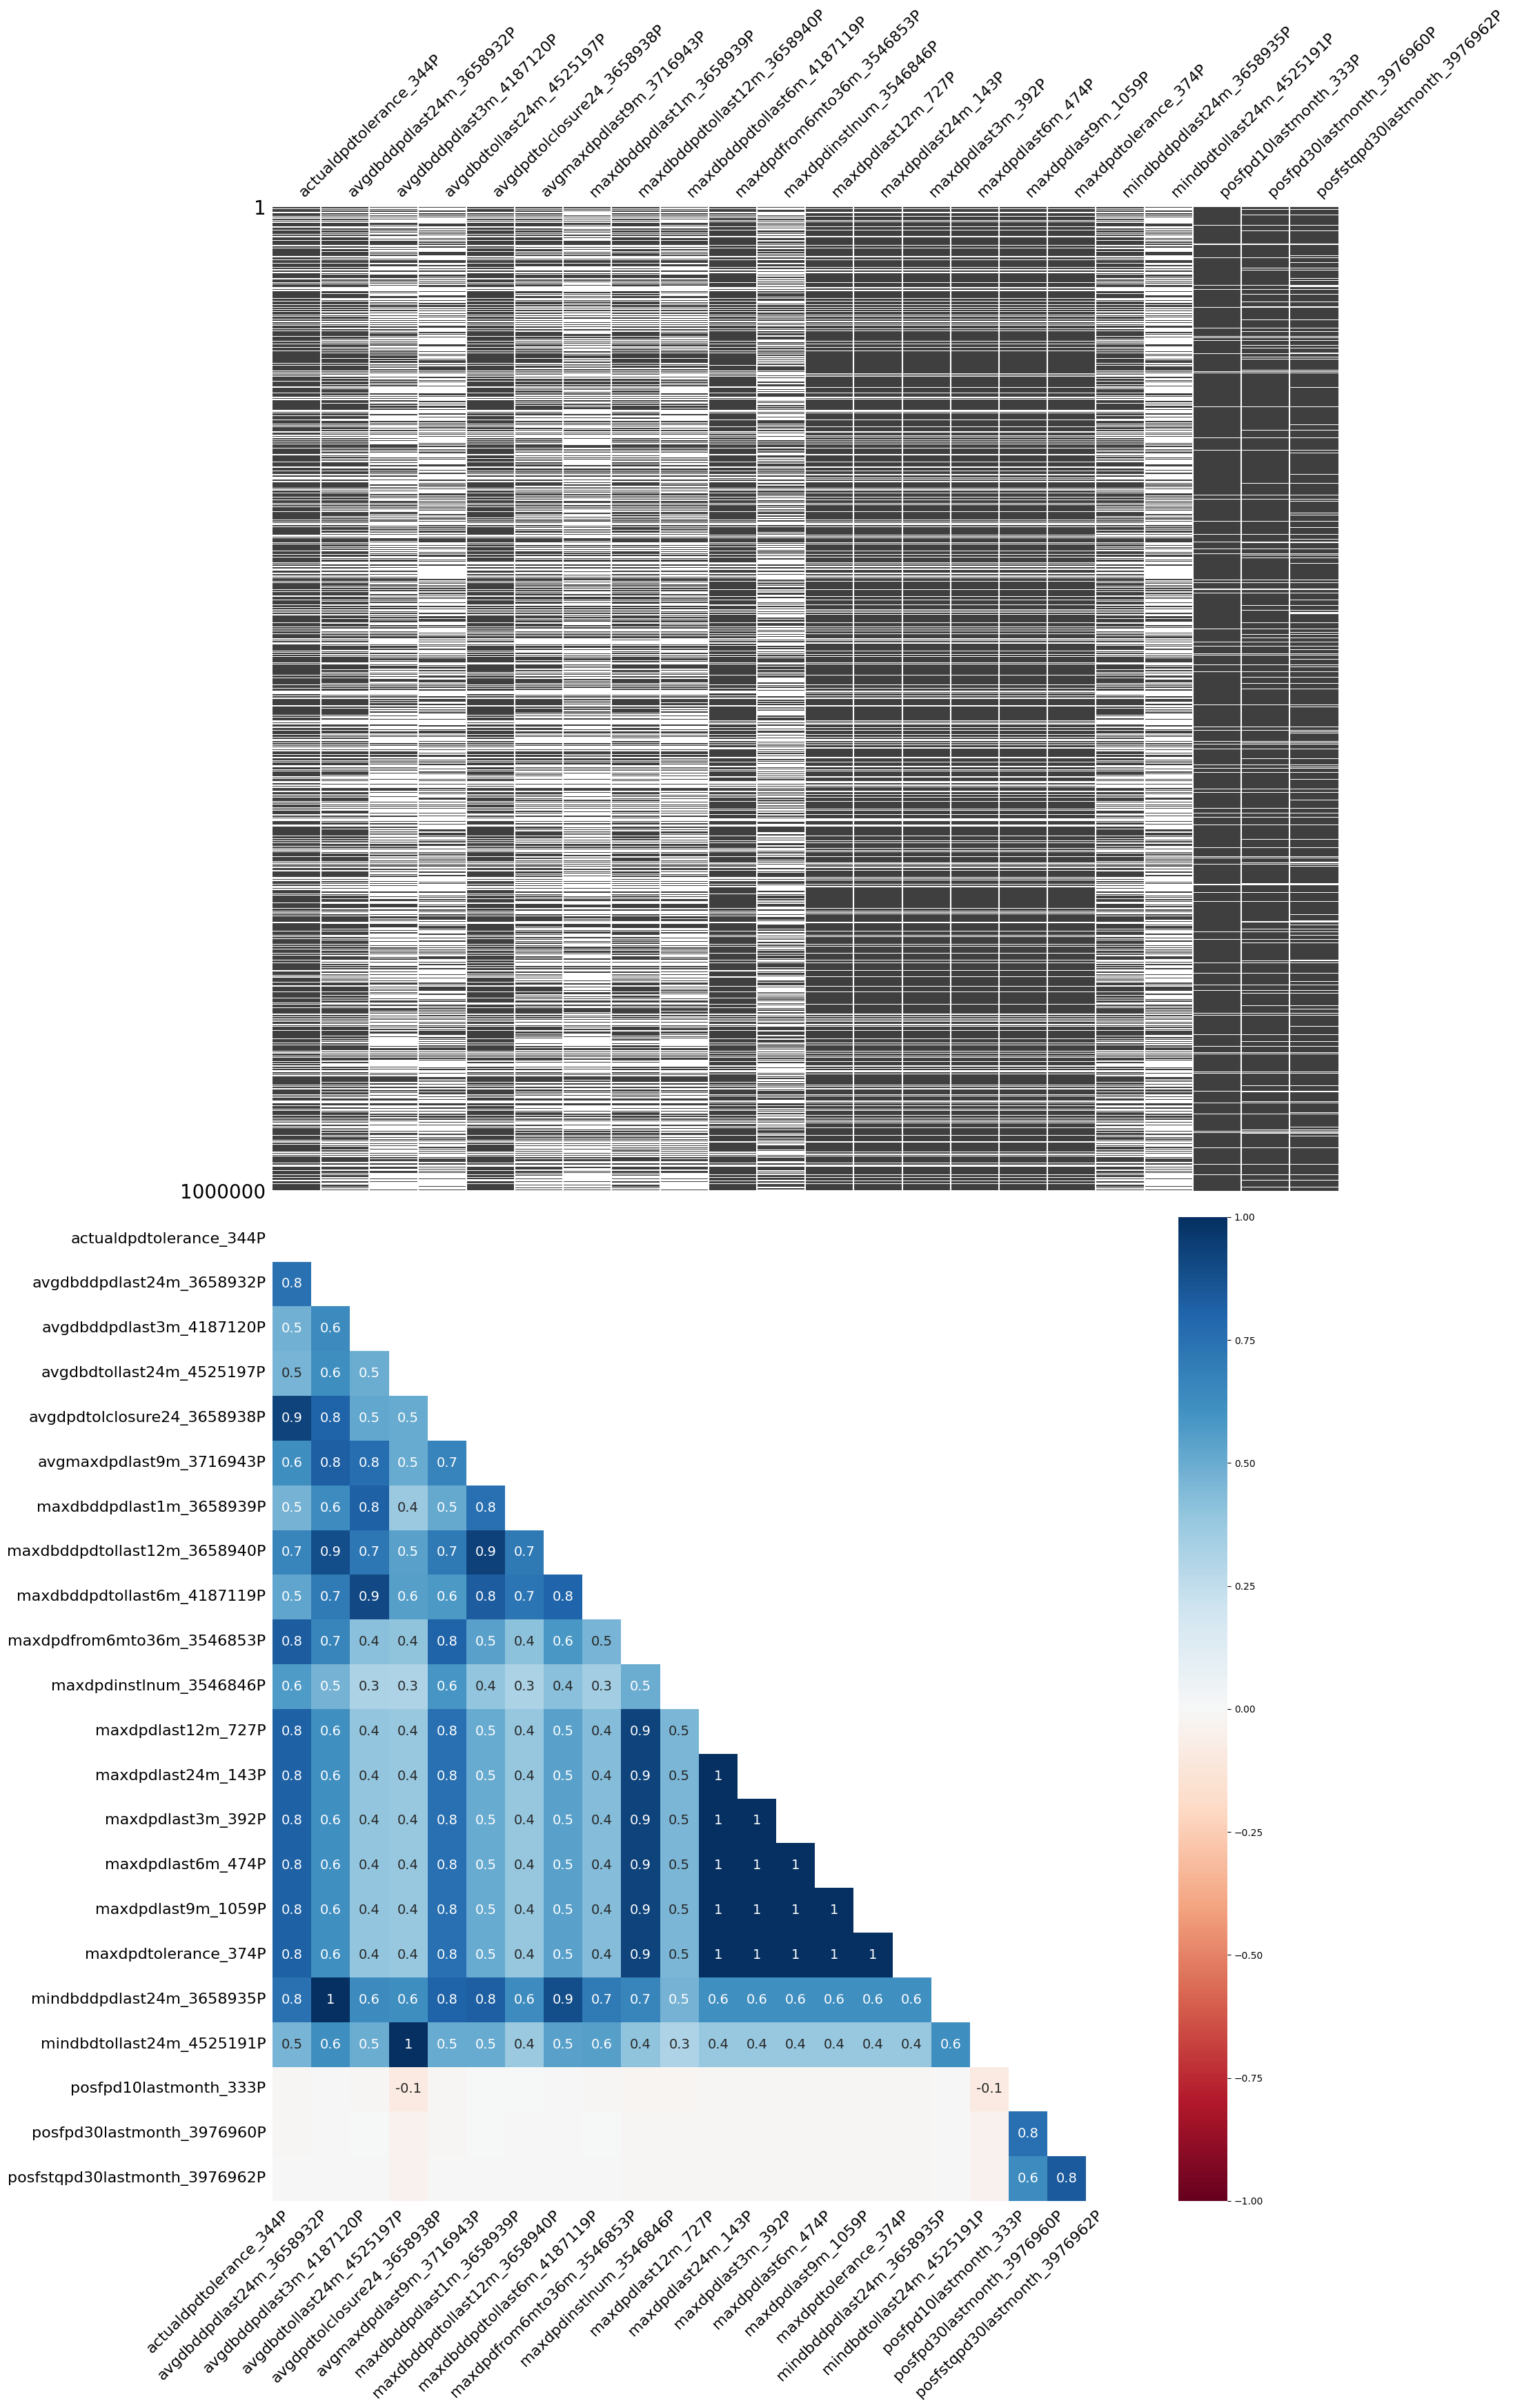

In [38]:
plot_null(df_train_static_0, 'P')

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


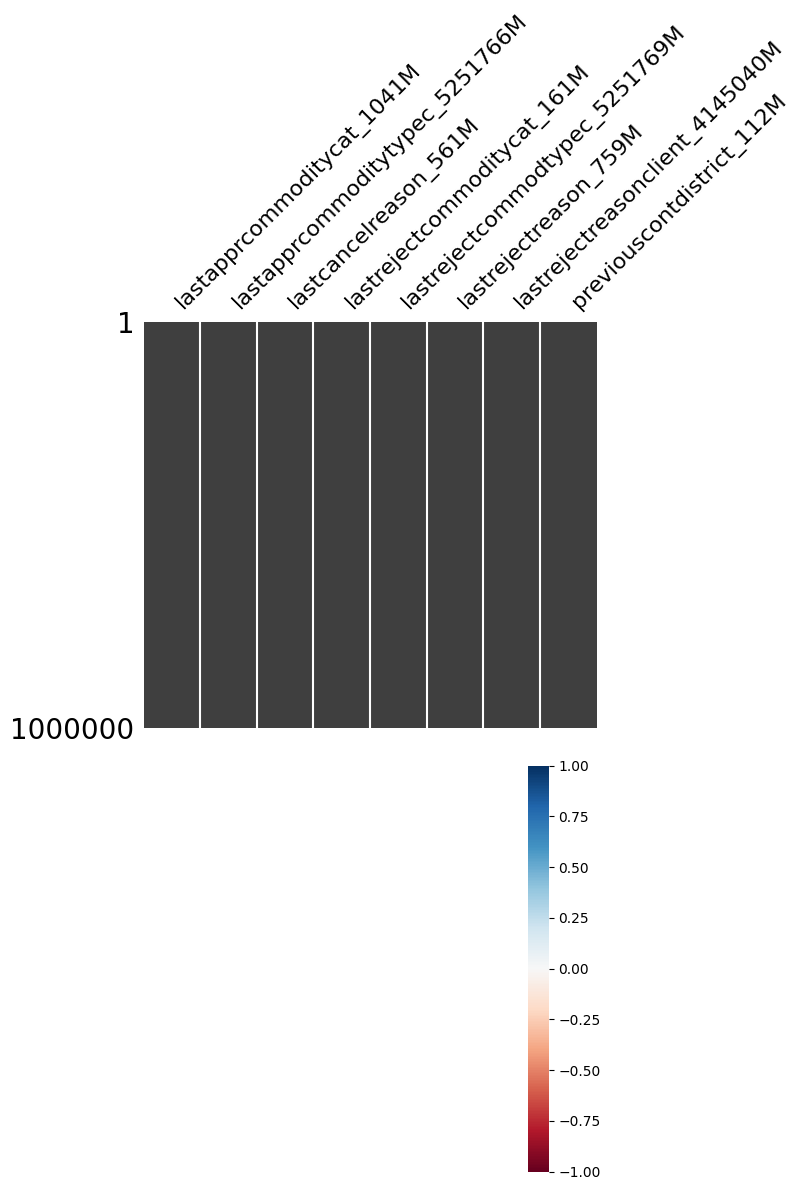

In [39]:
plot_null(df_train_static_0, 'M')

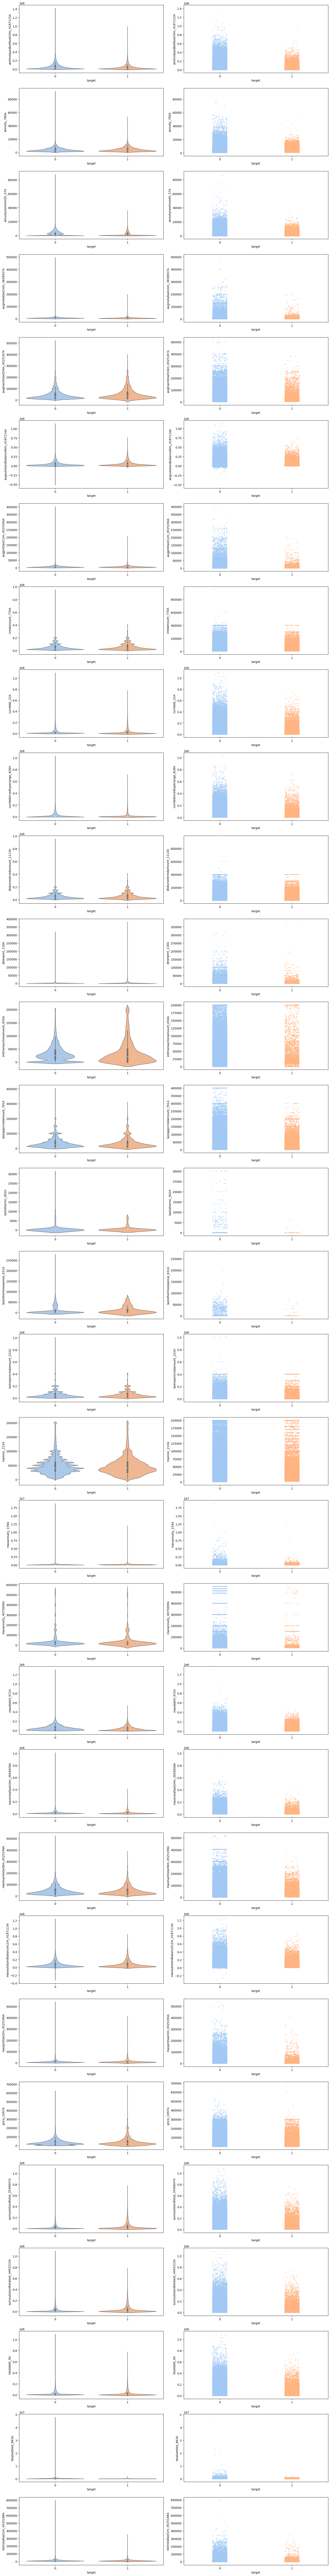

In [62]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plot_numerical_by_target(df_train_base, df_train_static_0, 'A')